## Import Libraries
- numpy
- kmodes (download kmodes library)
- pandas
- ast
- matplotlib
- seaborn

In [1]:
%pip install kmodes --quiet
%pip install gower --quiet
%pip install optuna --quiet
%pip install gower validclust --quiet
%pip install scikit-learn-extra --quiet
%pip install plotly --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import gower
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import optuna
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


## Load Data
Dataset of all NDRMMC tropical cyclone records from 2021-2025


https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/hirajya/K-Prototypes-Clustering-Algorithm-for-Post-Tropical-Cyclone-Impact-Profiling-in-the-Philippines/refs/heads/main/tropical_cyclones_records.csv')
df.head()

,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,Missing,Totally,Partially,Total,Quantity,Cost,Type,Category
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,22690.0,13172269.32,"['BLANKET', 'BUTANE GAS STOVE', 'CANISTER', 'F...","['FAMILY FOOD PACK', 'HYGIENE KIT', 'KITCHEN K..."
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,4800.0,2948690,"['FAMILY FOOD PACK', 'FINANCIAL', 'HYGIENE KIT...","['FAMILY FOOD PACK', 'FINANCIAL / SOCIAL ASSIS..."
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,228.0,46740,['FAMILY FOOD PACK'],['FAMILY FOOD PACK']
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,NaN,NaN,NaN,5.0,0.0,5.0,NaN,NaN,NaN,NaN
4,AGATON,2022,6,ILOILO,ALIMODIAN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9228 entries, 0 to 9227
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Typhoon Name       9228 non-null   object 
 1   Year               9228 non-null   int64  
 2   Region             9228 non-null   object 
 3   Province           9228 non-null   object 
 4   City/Municipality  9206 non-null   object 
 5   Families           8704 non-null   float64
 6   Person             8704 non-null   float64
 7   Brgy               8704 non-null   float64
 8   Dead               507 non-null    float64
 9   Injured/Ill        507 non-null    float64
 10  Missing            507 non-null    float64
 11  Totally            3815 non-null   float64
 12  Partially          3815 non-null   float64
 13  Total              3815 non-null   float64
 14  Quantity           3638 non-null   float64
 15  Cost               3769 non-null   object 
 16  Type               3523 

## Data Preprocessing

### 1.1 Standardization of data

Fix column names for consistency and readability & convert all of them to lowercase snakecase




In [6]:
df.rename(columns={'Category': 'Category_Aid'}, inplace=True)


In [7]:
df.columns = df.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

print("Columns now:", list(df.columns))

Columns now: ['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'type', 'category_aid']


In [8]:
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

Remove unnecessary columns
- type (baseline simplication basis of category)
- quantity (inconsistent values, same depth across all aids, not realiable)

In [9]:
df.drop(['type', 'quantity'], axis=1, inplace=True)

### 1.2 Handling Categorical & Impact Missing Values
Print the NaN/null values



In [10]:
df.isnull().sum()

typhoon_name            0
year                    0
region                  0
province                0
city_municipality      22
families              524
person                524
brgy                  524
dead                 8721
injured_ill          8721
missing              8721
totally              5413
partially            5413
total                5413
cost                 5462
category_aid         5714
dtype: int64

category -> replace NaN with ```['NOT SPECIFIED]```'

In [11]:
df['category_aid'] = df['category_aid'].fillna("['NOT SPECIFIED']")

city_municipality -> replace NaN with ```'UNKNOWN'```

In [12]:
df['city_municipality'] = df['city_municipality'].fillna('UNKNOWN')

impact-related columns ```(families, brgy, dead, injured_ill, missing, totally, partially, total)``` replace NaN with 0

In [13]:
zero_fill_cols = [
    'families', 'person', 'brgy',
    'dead', 'injured_ill', 'missing',
    'totally', 'partially', 'total'
]

df[zero_fill_cols] = df[zero_fill_cols].fillna(0)

In [14]:
# Count rows where 'person' is 0
zero_person_count = df[df['person'] == 0].shape[0]
print(f"Number of rows with 0 persons: {zero_person_count}")

# Remove rows where 'person' is 0
df = df[df['person'] > 0].copy()
print(f"Remaining rows after removal: {df.shape[0]}")

Number of rows with 0 persons: 980
Remaining rows after removal: 8248


In [15]:
for col in ['region', 'province', 'city_municipality']:
    df[col] = df[col].str.upper()

### 1.3 Verification Tagging
Events are tagged as either verified or unverified by the means of data

parse category column string to list

In [16]:
def parse_category(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x]
    except:
        return  ['NOT SPECIFIED']

df['category_aid'] = df['category_aid'].apply(parse_category)


**Verified events:** contain significant values in key columns (e.g. families, person, cost)

**Unverified events:** lacks significant values and having a unspecified categories (categories that equals to ```['NOT SPECIFIED']```, ```['NO BREAKDOWN']```, ```['FOR VERIFCATION']```)

In [17]:
category_counts = df['category_aid'].explode().value_counts()
print(category_counts)

category_aid
NOT SPECIFIED                            5194
FAMILY FOOD PACK                         2284
FINANCIAL / SOCIAL ASSISTANCE             670
OTHERS                                    602
HYGIENE KIT                               354
SLEEPING KIT                              288
NO BREAKDOWN                              169
KITCHEN KIT                               166
SHELTER KIT                               109
READY TO EAT FOOD                         105
FOR VERIFICATION                          103
CLOTHING KIT                               73
LOGISTICAL SUPPORT                         22
MEDICAL                                     6
READY TO EAT FOOD, LOGISTICAL SUPPORT       1
LIVELIHOOD                                  1
READY TO EAT FOOD, CLOTHING KIT             1
Name: count, dtype: int64


In [18]:
unverified_mask = df['category_aid'].apply(
    lambda x: any(item in ['NOT SPECIFIED', 'NO BREAKDOWN', 'FOR VERIFICATION'] for item in x)
)

In [19]:
unverified_mask.value_counts()

category_aid
True     5466
False    2782
Name: count, dtype: int64

### 1.4 Handling Missing Data using Unverified Masked

cost -> replace NaN with median cost (from tagged verified records only)

In [20]:
valid_cost_mask = ~unverified_mask & df['cost'].notna()
cost_median = df[valid_cost_mask]['cost'].median()

df.loc[~unverified_mask & df['cost'].isna(), 'cost'] = cost_median
df['cost'] = df['cost'].fillna(0) # final fallback

### 1.5 Simplication Mapping and Encoding of Category

*   Simplify and consolidate raw categories into fewer, more meaningful groups
*   Apply one-hot encoding to thematic varaibles for downstream analysis



In [21]:
def clean_and_split(lst):
    cleaned = []
    for item in lst:
        item = str(item).strip()
        # Handle combined: "READY TO EAT FOOD, CLOTHING KIT"
        if ',' in item and any(k in item for k in ['KIT', 'FOOD']):
            parts = [p.strip() for p in item.split(',') if p.strip()]
            cleaned.extend(parts)
        else:
            cleaned.append(item)
    return [c for c in cleaned if c not in ['', 'UNVERIFIED']]

# apply
df['category_aid'] = df['category_aid'].apply(clean_and_split)

In [22]:
# Mapping for normalization
mapping = {
    'NOT SPECIFIED': 'UNVERIFIED',
    'NO BREAKDOWN': 'UNVERIFIED',
    'FOR VERIFICATION': 'UNVERIFIED',
    'READY TO EAT FOOD': 'READY-TO-EAT MEALS',
    'CLOTHING KIT': 'CLOTHING',
    'LOGISTICAL SUPPORT': 'LOGISTICS',
    'MEDICAL': 'MEDICAL ASSISTANCE',
    'OTHERS': 'OTHER / UNSPECIFIED'
}

def standardize(item):
    return mapping.get(item.upper(), item.upper())  # normalize via mapping

def get_themes(items):
    themes = set()
    for item in items:
        item = standardize(item)
        if any(k in item for k in ['FAMILY FOOD PACK', 'READY-TO-EAT MEALS']):
            themes.add('Food')
        elif 'FINANCIAL' in item or 'SOCIAL ASSISTANCE' in item:
            themes.add('Cash')
        elif 'HYGIENE KIT' in item or 'MEDICAL ASSISTANCE' in item:
            themes.add('Hygiene & Health')
        elif 'SLEEPING KIT' in item or 'KITCHEN KIT' in item:
            themes.add('Sleeping Essentials')
        elif 'SHELTER KIT' in item or 'CLOTHING' in item or 'TARP' in item:
            themes.add('Shelter Support')
        elif 'LOGISTICS' in item:
            themes.add('Logistics')
        elif 'OTHER / UNSPECIFIED' in item:
            themes.add('Other')
        else:
            themes.add('Unverified')
    return list(themes)

# apply
df['aid_themes'] = df['category_aid'].apply(get_themes)

In [23]:
for theme in ['Food', 'Cash', 'Hygiene & Health', 'Sleeping Essentials', 'Shelter Support']:
    col_name = f'has_{theme.lower().replace(" & ", "_").replace(" ", "_")}'
    df[col_name] = df['aid_themes'].apply(lambda x: 1 if theme in x else 0)

In [24]:
# Show distribution of themes
all_themes = [t for themes in df['aid_themes'] for t in themes]
theme_counts = pd.Series(all_themes).value_counts()
print(theme_counts)

Unverified             5467
Food                   2323
Cash                    670
Other                   602
Hygiene & Health        356
Sleeping Essentials     327
Shelter Support         169
Logistics                23
Name: count, dtype: int64


In [25]:
df.drop(['aid_themes', 'category_aid'], axis=1, inplace=True)

#### See the miscorrect region input

In [26]:
pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # show all columns if needed

print(df['region'].value_counts())


region
4A        1042
3         1028
5          991
6          924
1          853
2          701
CAR        601
4B         514
8          490
7          268
BARMM      151
10         150
CARAGA     146
NCR        135
12          74
11          67
9           64
13          49
Name: count, dtype: int64


In [27]:
misamis_oriental_df = df[df['province'] == 'MISAMIS ORIENTAL']


In [28]:
agusan_del_norte_df = df[df['province'] == 'AGUSAN DEL NORTE']


In [29]:
surigao_del_sur_df = df[df['province'] == 'SURIGAO DEL SUR']


In [30]:
surigao_del_norte_df = df[df['province'] == 'SURIGAO DEL NORTE']


In [31]:
negros_oriental_df = df[df['province'] == 'NEGROS ORIENTAL']


In [32]:
df['region'] = df['region'].replace({'13': 'CARAGA'})

df.loc[df['province'] == 'MISAMIS ORIENTAL', 'region'] = '10'
df.loc[df['province'] == 'AGUSAN DEL NORTE', 'region'] = 'CARAGA'
df.loc[df['province'] == 'SURIGAO DEL SUR', 'region'] = 'CARAGA'
df.loc[df['province'] == 'SURIGAO DEL NORTE', 'region'] = 'CARAGA'
df.loc[df['province'] == 'NEGROS ORIENTAL', 'region'] = '7'


In [33]:
import pandas as pd

pd.set_option("display.max_rows", None)   # show all rows
pd.set_option("display.max_columns", None)  # show all columns if needed

print(df['region'].value_counts())


region
4A        1042
3         1028
5          991
6          923
1          853
2          701
CAR        601
4B         514
8          490
7          269
CARAGA     195
10         161
BARMM      151
NCR        135
12          74
11          66
9           54
Name: count, dtype: int64


In [34]:
df.head()

,typhoon_name,year,region,province,city_municipality,families,person,brgy,dead,injured_ill,missing,totally,partially,total,cost,has_food,has_cash,has_hygiene_health,has_sleeping_essentials,has_shelter_support
0,AGATON,2022,8,LEYTE,ABUYOG,18957.0,68354.0,63.0,55.0,0.0,0.0,142.0,326.0,468.0,13172269.32,1,0,1,1,0
1,AGATON,2022,6,ILOILO,AJUY,17414.0,61983.0,34.0,1.0,0.0,0.0,236.0,856.0,1092.0,2948690.00,1,1,1,1,0
2,AGATON,2022,8,LEYTE,ALANGALANG,1323.0,5444.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,46740.00,1,0,0,0,0
3,AGATON,2022,8,LEYTE,ALBUERA,203.0,1008.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.00,0,0,0,0,0
5,AGATON,2022,8,BILIRAN,ALMERIA,125.0,488.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0,0,0


## Feature Engineering

### 2.1 Transformation from Event-Based to Province-Based Data

*   Create a composite ID = ```(province, region)```

Aggregate data by composite ID:
* Sum ```(families, person, dead, injured_ill, missing, totally, partially, cost)```
* Sum ```(has_food, has_cash, has_hygiene_health, has_sleeping_essentials, has_shelter_support)```
* Count Number of typhoon events using nunique
* First and last year for recurrence rate, year min max







In [35]:
# --- Step 1. Clean and prepare typhoon names ---
df['typhoon_name_clean'] = df['typhoon_name'].str.strip()

# Create exploded version for individual typhoons
df['typhoon_list'] = df['typhoon_name_clean'].str.split('-')
df_exploded = df.explode('typhoon_list')
df_exploded['typhoon_list'] = df_exploded['typhoon_list'].str.strip()

# --- Step 2. Aggregation dictionary (without typhoon_name nunique here) ---
agg_dict = {
    # Impact & Damage (sum)
    'families': 'sum',
    'person': 'sum',
    'dead': 'sum',
    'injured_ill': 'sum',
    'missing': 'sum',
    'totally': 'sum',
    'partially': 'sum',
    'cost': 'sum',

    # Aid flags (mean across events)
    'has_food': 'sum',
    'has_cash': 'sum',
    'has_hygiene_health': 'sum',
    'has_sleeping_essentials': 'sum',
    'has_shelter_support': 'sum',

    # First and last year for recurrence rate
    'year': ['min', 'max'],
}

# --- Step 3. Province-level aggregation for impact & aid ---
province_df = df.groupby(['province', 'region']).agg(agg_dict).reset_index()

# Flatten column names after multi-level aggregation
province_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in province_df.columns]
province_df = province_df.rename(columns={
    'province': 'province_',
    'region': 'region_',
    'year_min': 'first_year',
    'year_max': 'last_year'
})

# --- Step 4. Province-level typhoon counts ---

# (a) Count unique report names (original merged names)
province_reports = (
    df.groupby(['province', 'region'])
      .agg({'typhoon_name_clean': 'nunique'})
      .reset_index()
      .rename(columns={'typhoon_name_clean': 'num_reports'})
)

# (b) Count unique individual typhoons (after split/explode)
province_typhoons = (
    df_exploded.groupby(['province', 'region'])
               .agg({'typhoon_list': 'nunique'})
               .reset_index()
               .rename(columns={'typhoon_list': 'num_typhoons'})
)

# --- Step 5. Merge into final province_df ---
province_df = (
    province_df
    .merge(province_reports, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .merge(province_typhoons, left_on=['province_', 'region_'], right_on=['province', 'region'], how='left')
    .drop(columns=['province_x', 'region_x', 'province_y', 'region_y'])
)


In [36]:
province_df

,province_,region_,families_sum,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,first_year,last_year,num_reports,num_typhoons
0,ABRA,CAR,191000.0,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,2021,2025,17,29
1,AGUSAN DEL NORTE,CARAGA,45045.0,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,2021,2025,7,9
2,AGUSAN DEL SUR,CARAGA,55722.0,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,2021,2024,4,5
3,AKLAN,6,170922.0,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,2021,2025,13,22
4,ALBAY,5,620755.0,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,2020,2025,16,25
5,ANTIQUE,6,245161.0,905657.0,16.0,0.0,6.0,3657.0,27281.0,1.298422e+08,99,74,10,19,2,2020,2025,16,26
6,APAYAO,CAR,49362.0,180378.0,0.0,3.0,0.0,63.0,4940.0,1.488750e+07,46,27,10,4,1,2020,2025,16,24
7,AURORA,3,102401.0,350627.0,3.0,29.0,0.0,882.0,6551.0,5.223061e+07,19,1,2,1,3,2020,2025,17,28
8,BASILAN,BARMM,1387.0,6568.0,0.0,0.0,0.0,34.0,147.0,0.000000e+00,0,0,0,0,0,2022,2025,4,10
9,BATAAN,3,650913.0,2550429.0,0.0,5.0,0.0,61.0,123.0,3.338718e+07,10,3,1,0,0,2020,2025,17,25


### 2.2 Derived Features

*   new column for ```recurrence_rate``` = num of typhoons / (last year - first year + 1)
*   new column for ```cost_per_family``` = cost_sum / families_sum[link text](https://)



In [37]:
province_df['recurrence_rate'] = province_df['num_typhoons'] / (
    province_df['last_year'] - province_df['first_year'] + 1
)

In [38]:
province_df['cost_per_family'] = province_df.apply(
    lambda row: row['cost_sum'] / row['families_sum'] if row['families_sum'] > 0 else np.nan,
    axis=1
)

In [39]:
province_df.isnull().sum()

province_                      0
region_                        0
families_sum                   0
person_sum                     0
dead_sum                       0
injured_ill_sum                0
missing_sum                    0
totally_sum                    0
partially_sum                  0
cost_sum                       0
has_food_sum                   0
has_cash_sum                   0
has_hygiene_health_sum         0
has_sleeping_essentials_sum    0
has_shelter_support_sum        0
first_year                     0
last_year                      0
num_reports                    0
num_typhoons                   0
recurrence_rate                0
cost_per_family                0
dtype: int64

## Feature Selection
Building correlation matrix and removing
```families_sum, first_year, last_year, total```

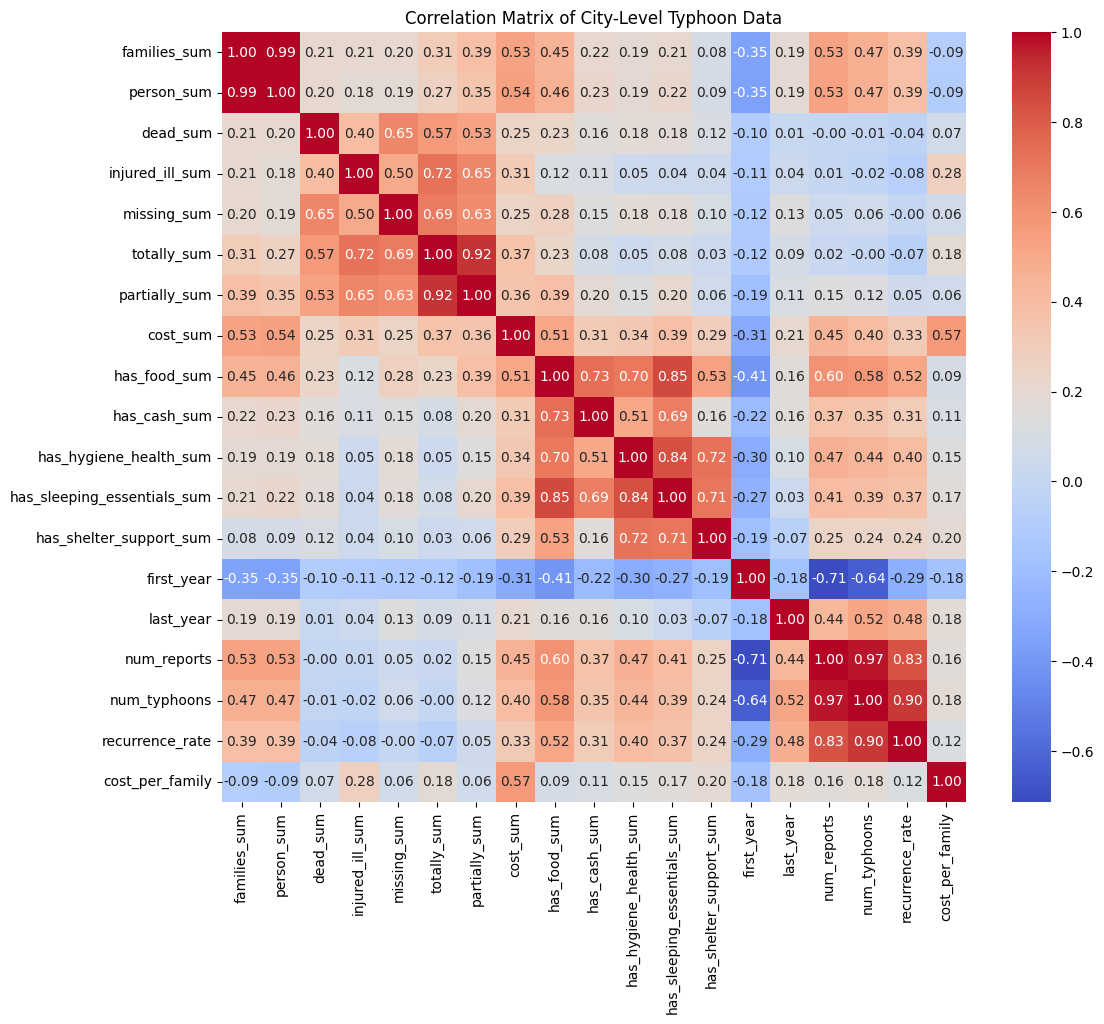

In [40]:
correlation_matrix = province_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of City-Level Typhoon Data')
plt.show()

In [41]:
standard_df = province_df.copy()

In [42]:
province_df.drop(['families_sum', 'first_year', 'last_year', 'num_reports'], axis=1, inplace=True)


#### Changing the index to province + region

In [43]:
# Create a unique province-region ID
province_df['province_region'] = province_df['province_'] + ' (' + province_df['region_'] + ')'

# Set it as index (optional but clean)
province_df.set_index('province_region', inplace=True)

# Now drop the original 'province_' column
province_df.drop(columns=['province_'], inplace=True)

In [44]:
province_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family'],
      dtype='object')

In [45]:
province_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,29,5.800000,154.257011
AGUSAN DEL NORTE (CARAGA),CARAGA,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,9,1.800000,451.313549
AGUSAN DEL SUR (CARAGA),CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,5,1.250000,120.374087
AKLAN (6),6,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,22,4.400000,388.050105
ALBAY (5),5,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,25,4.166667,246.731259


In [46]:
province_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92 entries, ABRA (CAR) to ZAMBOANGA SIBUGAY (9)
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   region_                      92 non-null     object 
 1   person_sum                   92 non-null     float64
 2   dead_sum                     92 non-null     float64
 3   injured_ill_sum              92 non-null     float64
 4   missing_sum                  92 non-null     float64
 5   totally_sum                  92 non-null     float64
 6   partially_sum                92 non-null     float64
 7   cost_sum                     92 non-null     float64
 8   has_food_sum                 92 non-null     int64  
 9   has_cash_sum                 92 non-null     int64  
 10  has_hygiene_health_sum       92 non-null     int64  
 11  has_sleeping_essentials_sum  92 non-null     int64  
 12  has_shelter_support_sum      92 non-null     int64  
 13 

In [47]:
province_df.shape

(92, 16)

In [48]:
province_df.to_csv('province_typhoon_data_standard.csv', index=False)

In [49]:
province_df.describe()

,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
count,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,7.701322e+05,8.684783,24.445652,1.010870,5988.869565,26503.510870,6.046428e+07,25.250000,7.282609,3.869565,3.554348,1.836957,16.717391,3.236775,351.582352
std,1.082292e+06,21.963471,64.763537,2.674645,18259.178563,72546.093399,8.770663e+07,34.555458,16.281403,6.702824,6.818469,4.289720,8.067471,1.175741,422.115878
min,4.900000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.750000,0.000000
25%,6.445600e+04,0.000000,0.000000,0.000000,46.500000,230.250000,2.761906e+06,2.000000,0.000000,0.000000,0.000000,0.000000,10.750000,2.250000,135.073876
50%,3.693375e+05,2.000000,1.000000,0.000000,216.000000,1510.500000,2.551739e+07,12.500000,1.500000,1.000000,1.000000,0.000000,16.000000,3.225000,263.429354
75%,9.645732e+05,6.250000,10.000000,0.250000,2393.250000,20713.250000,7.669189e+07,35.500000,5.000000,6.000000,5.000000,1.250000,24.000000,4.200000,431.329763
max,6.318463e+06,155.000000,374.000000,15.000000,127560.000000,580822.000000,4.775400e+08,205.000000,104.000000,46.000000,35.000000,28.000000,31.000000,5.800000,2463.921656


## EDA

In [50]:
standard_df.head()

,province_,region_,families_sum,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,first_year,last_year,num_reports,num_typhoons,recurrence_rate,cost_per_family
0,ABRA,CAR,191000.0,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,2021,2025,17,29,5.800000,154.257011
1,AGUSAN DEL NORTE,CARAGA,45045.0,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,2021,2025,7,9,1.800000,451.313549
2,AGUSAN DEL SUR,CARAGA,55722.0,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,2021,2024,4,5,1.250000,120.374087
3,AKLAN,6,170922.0,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,2021,2025,13,22,4.400000,388.050105
4,ALBAY,5,620755.0,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,2020,2025,16,25,4.166667,246.731259


In [51]:
print(f"We have a total of {standard_df.shape[0]} provinces + independent cities + NCR(united as one)")
# "BUTUAN CITY", "COTABATO CITY", "DAGUPAN", "DAVAO CITY", "ISABELA CITY", "NAGA", "OLONGAPO", "ZAMBOANGA CITY" list of independent cities

We have a total of 92 provinces + independent cities + NCR(united as one)


In [52]:
standard_df.columns

Index(['province_', 'region_', 'families_sum', 'person_sum', 'dead_sum',
       'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum',
       'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum',
       'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'first_year',
       'last_year', 'num_reports', 'num_typhoons', 'recurrence_rate',
       'cost_per_family'],
      dtype='object')


Province count per region:
 region_
1         5
10        5
11        6
12        4
2         5
3         8
4A        5
4B        5
5         7
6         6
7         4
8         6
9         5
BARMM     8
CAR       6
CARAGA    6
NCR       1
Name: province_, dtype: int64


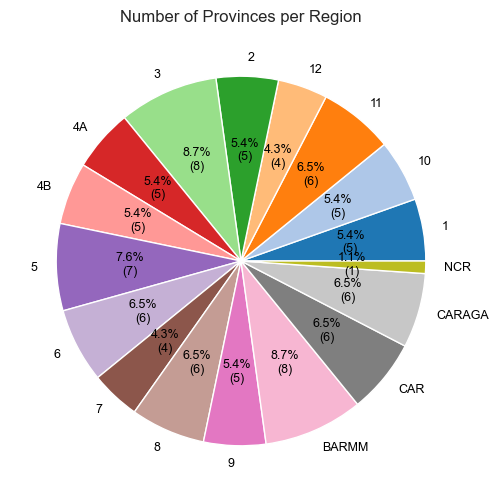

In [53]:
sns.set(style="whitegrid")

# 1. Province count per region (Pie chart with exact count + %)
province_count = standard_df.groupby('region_')['province_'].nunique()
print("\nProvince count per region:\n", province_count)

# Generate colors safely
colors = cm.tab20.colors[:len(province_count)]

# Pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    province_count,
    labels=province_count.index,
    colors=colors,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p*sum(province_count)/100))})",
    textprops={'fontsize': 9, 'color': 'black'}
)
plt.title("Number of Provinces per Region", fontsize=12)
plt.show()


Persons affected per region:
 region_
3         15558849.0
5          9829248.0
6          8667010.0
1          6363124.0
4A         6182754.0
8          4816719.0
7          4578288.0
NCR        2730661.0
BARMM      2496402.0
2          2485773.0
4B         2212341.0
CARAGA     1964496.0
CAR        1226900.0
12          859385.0
9           353763.0
11          278819.0
10          247626.0
Name: person_sum, dtype: float64


C:\Users\Rodney Lei Estrada\AppData\Local\Temp\ipykernel_10356\3510998663.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=person_region.index, y=person_region.values, palette="Blues_r")


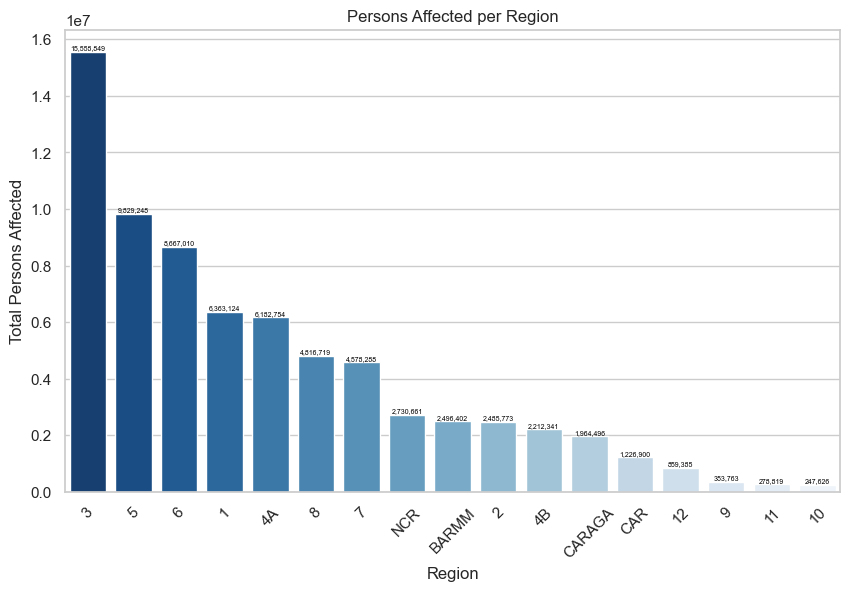

In [54]:
# 2. Persons affected per region (Bar chart, formatted numbers)
person_region = standard_df.groupby('region_')['person_sum'].sum().sort_values(ascending=False)
print("\nPersons affected per region:\n", person_region)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=person_region.index, y=person_region.values, palette="Blues_r")
plt.xticks(rotation=45)
plt.title('Persons Affected per Region')
plt.ylabel('Total Persons Affected')
plt.xlabel('Region')

for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=5, color='black')

plt.show()


Casualties per region:
          dead_sum  injured_ill_sum  missing_sum
region_                                        
1            35.0              3.0         10.0
10           10.0             34.0          0.0
11            5.0              1.0          1.0
12            3.0             17.0          0.0
2             9.0             31.0          2.0
3            15.0             82.0          0.0
4A           22.0              9.0          1.0
4B           48.0             21.0          8.0
5            25.0             47.0          1.0
6           119.0            175.0         15.0
7           214.0            547.0         32.0
8           181.0            414.0          6.0
9             7.0              1.0          0.0
BARMM        66.0            169.0         13.0
CAR          18.0            198.0          4.0
CARAGA       22.0            500.0          0.0
NCR           0.0              0.0          0.0


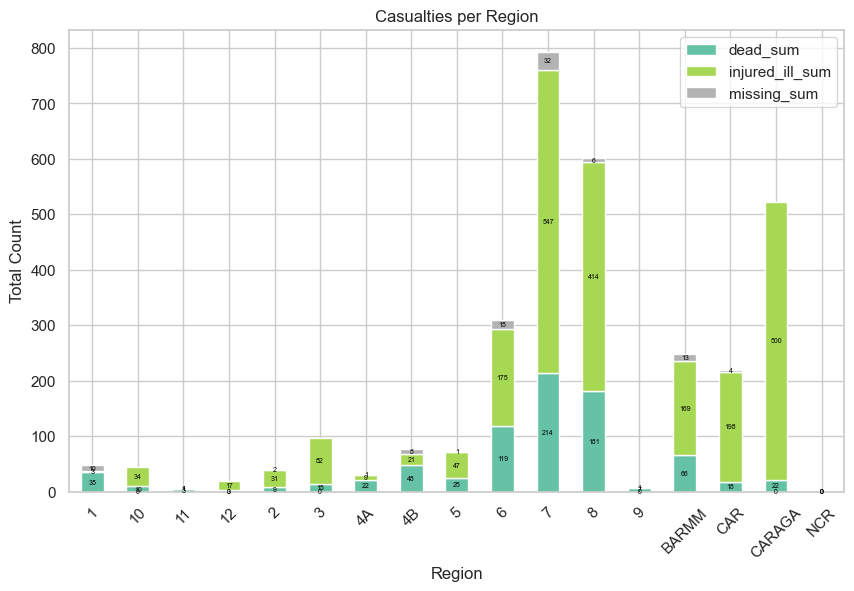

In [55]:
# 3. Casualties per region (Stacked Bar + labels)
casualties = standard_df.groupby('region_')[['dead_sum','injured_ill_sum','missing_sum']].sum()
print("\nCasualties per region:\n", casualties)

ax = casualties.plot(kind='bar', stacked=True, figsize=(10, 6), colormap="Set2")
plt.title('Casualties per Region')
plt.ylabel('Total Count')
plt.xlabel('Region')
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=5, color='black')

plt.show()


Top 15 provinces by number of typhoons:
 province_
BULACAN              31
CAGAYAN              31
ABRA                 29
MOUNTAIN PROVINCE    29
PAMPANGA             29
ZAMBALES             29
BENGUET              28
AURORA               28
ILOILO               27
ISABELA              27
Name: num_typhoons, dtype: int64


C:\Users\Rodney Lei Estrada\AppData\Local\Temp\ipykernel_10356\4269437818.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=typhoons.values, y=typhoons.index, palette="Reds_r")


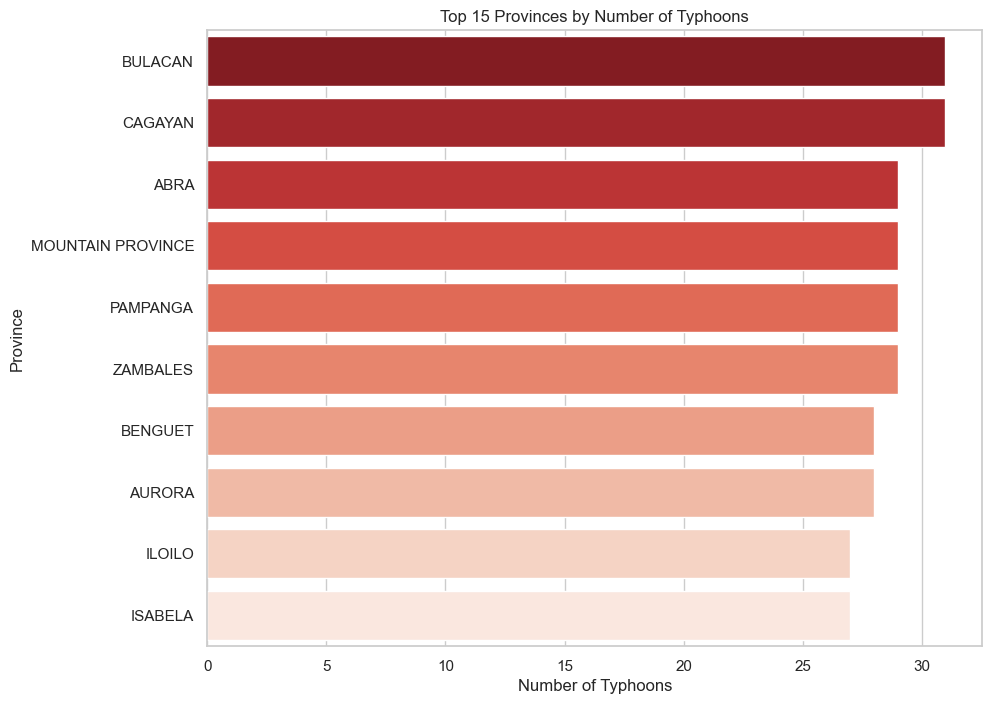

In [56]:
# 4. Top 15 Provinces by Number of Typhoons (Horizontal Bar)
typhoons = standard_df.groupby('province_')['num_typhoons'].max().sort_values(ascending=False).head(10)
print("\nTop 15 provinces by number of typhoons:\n", typhoons)

plt.figure(figsize=(10, 8))
ax = sns.barplot(x=typhoons.values, y=typhoons.index, palette="Reds_r")
plt.title('Top 15 Provinces by Number of Typhoons')
plt.xlabel('Number of Typhoons')
plt.ylabel('Province')
plt.show()


Aid/Support distribution per region:
          has_food_sum  has_cash_sum  has_hygiene_health_sum  \
region_                                                       
1                 158            12                      28   
10                 20             2                      10   
11                  7             3                       1   
12                 21            12                       3   
2                 350            32                      65   
3                 143             8                      15   
4A                 35            25                      20   
4B                195            14                      32   
5                 237            28                      11   
6                 542           321                      57   
7                 147             3                       0   
8                 154            37                      36   
9                  12             2                       3   
BARMM           

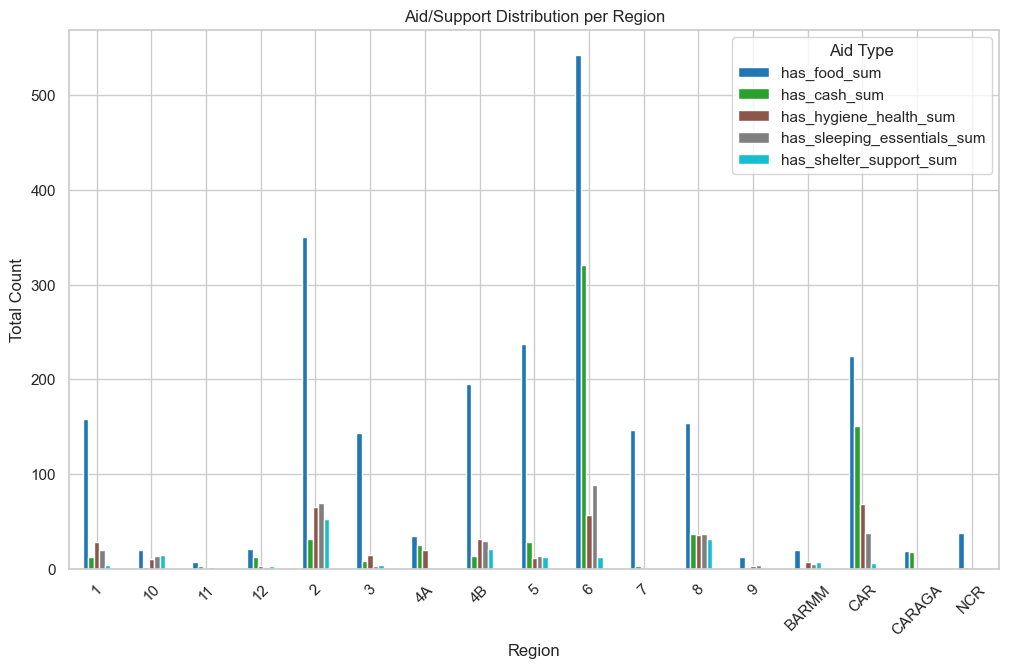

In [57]:
# 5. Aid/Support distribution per region (Grouped Bar)
aid = standard_df.groupby('region_')[['has_food_sum','has_cash_sum','has_hygiene_health_sum',
                                      'has_sleeping_essentials_sum','has_shelter_support_sum']].sum()
print("\nAid/Support distribution per region:\n", aid)

ax = aid.plot(kind='bar', figsize=(12, 7), colormap="tab10")
plt.title('Aid/Support Distribution per Region')
plt.ylabel('Total Count')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Aid Type')
plt.show()


Housing damage per region:
          totally_sum  partially_sum
region_                            
1            13898.0       157635.0
10             750.0         5987.0
11             425.0         2295.0
12             689.0         2741.0
2             3643.0        59089.0
3             1275.0         7718.0
4A           11879.0       113380.0
4B           22208.0       136926.0
5            59987.0       275794.0
6            59021.0       445374.0
7           245765.0       900987.0
8            61407.0       215707.0
9              524.0          786.0
BARMM         1345.0         1675.0
CAR            332.0         8136.0
CARAGA       67808.0       104093.0
NCR             20.0            0.0


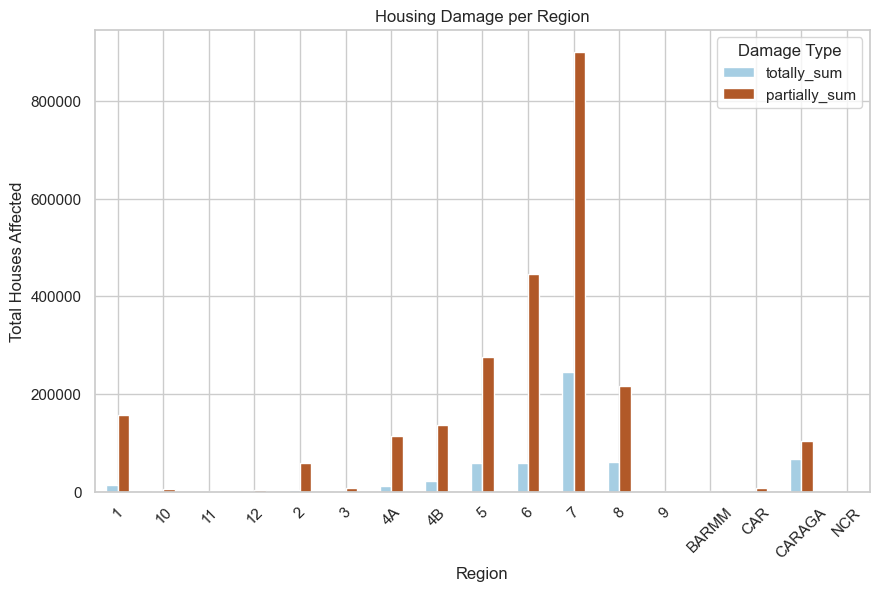

In [58]:
# 6. Housing damage per region (Grouped Bar)
damage = standard_df.groupby('region_')[['totally_sum','partially_sum']].sum()
print("\nHousing damage per region:\n", damage)

ax = damage.plot(kind='bar', figsize=(10, 6), colormap="Paired")
plt.title('Housing Damage per Region')
plt.ylabel('Total Houses Affected')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.legend(title='Damage Type')

plt.show()

In [59]:
# Get the total count of provinces
total_provinces = standard_df.shape[0]

# Get the total sum of families
total_families_sum = standard_df['families_sum'].sum()

# Get the total sum of people affected
total_person_sum = standard_df['person_sum'].sum()

# Print the results
print(f"Total number of provinces: {total_provinces}")
print(f"Total sum of families: {total_families_sum:,.0f}")
print(f"Total sum of people affected: {total_person_sum:,.0f}")

Total number of provinces: 92
Total sum of families: 18,693,326
Total sum of people affected: 70,852,158


In [60]:
standard_df.head()

,province_,region_,families_sum,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,first_year,last_year,num_reports,num_typhoons,recurrence_rate,cost_per_family
0,ABRA,CAR,191000.0,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,2021,2025,17,29,5.800000,154.257011
1,AGUSAN DEL NORTE,CARAGA,45045.0,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,2021,2025,7,9,1.800000,451.313549
2,AGUSAN DEL SUR,CARAGA,55722.0,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,2021,2024,4,5,1.250000,120.374087
3,AKLAN,6,170922.0,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,2021,2025,13,22,4.400000,388.050105
4,ALBAY,5,620755.0,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,2020,2025,16,25,4.166667,246.731259


#### Applying Standard Scaling

In [61]:
from sklearn.preprocessing import StandardScaler

final_df = province_df.copy()
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
print(f"numerical_columns: {numerical_cols}")

scaler = StandardScaler()
province_df[numerical_cols] = scaler.fit_transform(province_df[numerical_cols])

print("DataFrame after Standard Scaling:")
display(province_df.head())

numerical_columns: ['person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum', 'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum', 'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum', 'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate', 'cost_per_family']
DataFrame after Standard Scaling:


,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,-0.097266,-0.306027,1.405892,-0.380016,-0.326596,-0.355028,-0.355401,1.040238,2.391043,0.619600,0.065718,0.507002,1.530828,2.192040,-0.470029
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.539307,-0.397586,-0.379528,-0.380016,-0.171417,-0.237385,-0.460111,-0.705616,-0.449747,-0.580467,-0.524139,-0.430569,-0.961848,-1.228713,0.237560
AGUSAN DEL SUR (CARAGA),CARAGA,-0.509796,-0.397586,-0.379528,-0.380016,-0.320593,-0.357536,-0.616274,-0.647421,-0.449747,-0.580467,-0.524139,-0.430569,-1.460383,-1.699067,-0.550738
AKLAN (6),6,-0.123357,-0.031349,-0.348478,-0.004086,-0.314756,-0.235251,0.067203,0.749262,1.711724,-0.430459,-0.081746,-0.430569,0.658392,0.994776,0.086866
ALBAY (5),5,1.516830,-0.122908,-0.270851,-0.380016,0.731738,1.095006,1.062671,0.778360,-0.326234,0.169575,0.360646,1.444573,1.032293,0.795232,-0.249755


In [62]:
# PCA ANALYSIS WITH EXPLAINED VARIANCE + 3D VISUALIZATION

print("PCA ANALYSIS ON SCALED NUMERICAL FEATURES")

# --- Select numeric features ---
numeric_features = province_df.select_dtypes(include=np.number).columns.tolist()
X_viz = province_df[numeric_features].copy()

# --- Perform PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_viz)

# --- Calculate cumulative variance ---
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# --- Print explained variance summary ---
print(f"\nExplained Variance by Component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    cum_var = cumulative_variance[i-1]
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var*100:.2f}%")

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# --- Create explained variance table ---
explained_variance_table = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Variance': cumulative_variance
}).round(4)

print("\nExplained Variance Table:")
display(explained_variance_table.head(10))  # show first 10 PCs

# --- 3D PCA Visualization (no clusters) ---
pca_df = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
if 'province' in province_df.columns:
    pca_df['province'] = province_df['province']

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    hover_name='province' if 'province' in pca_df.columns else None,
    title=f'3D PCA Visualization (Explains {cumulative_variance[2]*100:.1f}% Variance)',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)'
    }
)

fig.update_traces(marker=dict(size=6, color='royalblue', line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(height=700)
fig.show()


PCA ANALYSIS ON SCALED NUMERICAL FEATURES

Explained Variance by Component:
  PC1: 0.3577 (35.77%) | Cumulative: 35.77%
  PC2: 0.2144 (21.44%) | Cumulative: 57.21%
  PC3: 0.1040 (10.40%) | Cumulative: 67.61%
  PC4: 0.0878 (8.78%) | Cumulative: 76.39%
  PC5: 0.0564 (5.64%) | Cumulative: 82.03%
  PC6: 0.0491 (4.91%) | Cumulative: 86.94%
  PC7: 0.0422 (4.22%) | Cumulative: 91.16%
  PC8: 0.0247 (2.47%) | Cumulative: 93.63%
  PC9: 0.0211 (2.11%) | Cumulative: 95.73%
  PC10: 0.0138 (1.38%) | Cumulative: 97.11%

Components needed for 90% variance: 7
Components needed for 95% variance: 9

Explained Variance Table:


,Principal Component,Explained Variance Ratio,Cumulative Variance
0,PC1,0.3577,0.3577
1,PC2,0.2144,0.5721
2,PC3,0.1040,0.6761
3,PC4,0.0878,0.7639
4,PC5,0.0564,0.8203
5,PC6,0.0491,0.8694
6,PC7,0.0422,0.9116
7,PC8,0.0247,0.9363
8,PC9,0.0211,0.9573
9,PC10,0.0138,0.9711


### Labeling Categorical and Numerical Data Columns

In [63]:
province_df.columns = province_df.columns.str.strip()
province_df['region_'] = province_df['region_'].astype(str)

categorical_columns = ['region_']
categorical_indices = [province_df.columns.get_loc(col) for col in categorical_columns]

### Silhoutte Score

In [64]:
# Prepare data for Gower (exclude nothing yet — we'll drop 'cluster' later if present)
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()

print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

k_range = range(2, 9)
silhouette_scores = []
costs = []

print("\nRunning K-Prototypes for k = 2 to 10...")
for k in k_range:
    print(f"  k = {k} ...", end="")

    # Run K-Prototypes
    kproto = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=10,
        verbose=0,
        random_state=42
    )

    X = province_df.drop(columns=['cluster'], errors='ignore').values.astype(object)
    clusters = kproto.fit_predict(X, categorical=categorical_indices)

    # Compute silhouette score using precomputed Gower distance
    sil_score = silhouette_score(gower_dist, clusters, metric='precomputed')

    # Store results
    silhouette_scores.append(sil_score)
    costs.append(kproto.cost_)

    print(f" Silhouette = {sil_score:.4f}, Cost = {kproto.cost_:.2f}")


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!

Running K-Prototypes for k = 2 to 10...
  k = 2 ... Silhouette = 0.4448, Cost = 1088.76
  k = 3 ... Silhouette = 0.3422, Cost = 922.96
  k = 4 ... Silhouette = 0.2124, Cost = 755.82
  k = 5 ... Silhouette = 0.2302, Cost = 667.27
  k = 6 ... Silhouette = 0.2326, Cost = 577.81
  k = 7 ... Silhouette = 0.1994, Cost = 518.32
  k = 8 ... Silhouette = 0.1519, Cost = 480.59


### Grid Search

In [ ]:

param_grid = {
    'n_clusters': range(2, 9),  # Number of clusters to test
    'init': ['Huang', 'Cao'],   # Initialization methods
    'n_init': [5, 10]          # Number of initializations
}

# Create a list of parameter combinations
grid = ParameterGrid(param_grid)

best_score = -1
best_params = None
results = []

print("Starting Grid Search for K-Prototypes...")
print("-" * 30)

# Prepare the data (Include data prep from the previous successful cell)
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

# Separate numerical and categorical data
X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

# Combine the data for K-Prototypes. K-Prototypes expects categorical features last.
X = np.concatenate((X_numerical, X_categorical), axis=1)

# Get the indices of categorical columns in the combined matrix
# They will be after all numerical columns
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance matrix (if using precomputed metric for silhouette)
# Make sure 'gower_dist' is computed before the loop if metric='precomputed'
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy() # Re-create if needed
print("Computing Gower distance matrix (one-time, may take a moment)...")
gower_dist = gower.gower_matrix(X_for_gower) # Compute if needed
print("Gower distance computed!")


for params in grid:
    n_clusters = params['n_clusters']
    init_method = params['init']
    n_init = params['n_init']

    print(f"Testing params: k={n_clusters}, init='{init_method}', n_init={n_init}")

    try:
        # Initialize and train K-Prototypes model
        kp = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            verbose=0, # Set verbose to 0 for cleaner grid search output
            random_state=42
        )
        clusters = kp.fit_predict(X, categorical=categorical_indices_combined)
        score = silhouette_score(gower_dist, clusters, metric='precomputed')


        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': score,
            'cost': kp.cost_
        })

        print(f"  Silhouette Score: {score:.4f}, Cost: {kp.cost_:.2f}")

        # Check for best score
        if score > best_score:
            best_score = score
            best_params = params

    except Exception as e:
        print(f"  Error with params {params}: {e}")
        results.append({
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'silhouette_score': None,
            'cost': None,
            'error': str(e)
        })


print("-" * 30)
print("\nGrid Search Complete.")
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Optional: Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='silhouette_score', ascending=False))

# Restore warnings
warnings.filterwarnings("default", category=DeprecationWarning)
warnings.filterwarnings("default", category=UserWarning)

Starting Grid Search for K-Prototypes...
------------------------------
Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!
Testing params: k=2, init='Huang', n_init=5
  Silhouette Score: 0.3447, Cost: 1090.74
Testing params: k=2, init='Huang', n_init=10
  Silhouette Score: 0.4448, Cost: 1088.76
Testing params: k=3, init='Huang', n_init=5
  Silhouette Score: 0.3422, Cost: 922.96
Testing params: k=3, init='Huang', n_init=10
  Silhouette Score: 0.3422, Cost: 922.96
Testing params: k=4, init='Huang', n_init=5
  Silhouette Score: 0.2124, Cost: 755.82
Testing params: k=4, init='Huang', n_init=10
  Silhouette Score: 0.2124, Cost: 755.82
Testing params: k=5, init='Huang', n_init=5
  Silhouette Score: 0.2302, Cost: 667.27
Testing params: k=5, init='Huang', n_init=10
  Silhouette Score: 0.2302, Cost: 667.27
Testing params: k=6, init='Huang', n_init=5
  Silhouette Score: 0.2326, Cost: 577.81
Testing params: k=6, init='Huang', n_init=10
  Silhouette Score: 0.

### Optuna Bayesian / Smart Search

In [ ]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*datetime.datetime.utcnow.*"
)


In [ ]:
numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include='object').columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)
categorical_indices_combined = list(range(X_numerical.shape[1], X.shape[1]))

# Compute Gower distance once for silhouette
print("Computing Gower distance matrix (one-time, may take a moment)...")
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)
print("Gower distance computed!")

def objective(trial):
    # n_clusters = trial.suggest_int("n_clusters", 2, 10)  # cluster range
    n_clusters = 3
    init_method = trial.suggest_categorical("init", ["Huang", "Cao"])
    n_init = trial.suggest_int("n_init", 5, 15)
    gamma = trial.suggest_float("gamma", 0.1, 5.0)  # categorical weight

    try:
        model = KPrototypes(
            n_clusters=n_clusters,
            init=init_method,
            n_init=n_init,
            gamma=gamma,
            verbose=0,
            random_state=42
        )
        clusters = model.fit_predict(X, categorical=categorical_indices_combined)

        # Use silhouette with precomputed Gower distance
        score = silhouette_score(gower_dist, clusters, metric="precomputed")
        return score

    except Exception as e:
        # Failures return very low score
        return -1.0

# Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # try 50 trials


print("\n📊 Optuna Search Complete!")
print("Best Silhouette Score:", study.best_value)
print("Best Parameters:", study.best_trial.params)

optuna_results = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_results = optuna_results.sort_values(by="value", ascending=False)
display(optuna_results.head(20))


[I 2025-10-08 08:38:44,084] A new study created in memory with name: no-name-b5cbb865-209d-4b16-82e0-592638b03dc4


Computing Gower distance matrix (one-time, may take a moment)...
Gower distance computed!


[I 2025-10-08 08:38:44,712] Trial 0 finished with value: 0.2813728451728821 and parameters: {'init': 'Cao', 'n_init': 9, 'gamma': 2.750753501133244}. Best is trial 0 with value: 0.2813728451728821.
[I 2025-10-08 08:38:44,906] Trial 1 finished with value: 0.34057503938674927 and parameters: {'init': 'Cao', 'n_init': 5, 'gamma': 4.392052027310087}. Best is trial 1 with value: 0.34057503938674927.
[I 2025-10-08 08:38:45,321] Trial 2 finished with value: 0.2813728451728821 and parameters: {'init': 'Cao', 'n_init': 10, 'gamma': 1.7991512156068665}. Best is trial 1 with value: 0.34057503938674927.
[I 2025-10-08 08:38:45,907] Trial 3 finished with value: 0.2813728451728821 and parameters: {'init': 'Cao', 'n_init': 14, 'gamma': 0.432178359198393}. Best is trial 1 with value: 0.34057503938674927.
[I 2025-10-08 08:38:46,390] Trial 4 finished with value: 0.2813728451728821 and parameters: {'init': 'Cao', 'n_init': 13, 'gamma': 1.1031655936691664}. Best is trial 1 with value: 0.34057503938674927.



📊 Optuna Search Complete!
Best Silhouette Score: 0.3576343357563019
Best Parameters: {'init': 'Huang', 'n_init': 6, 'gamma': 2.2366941491800234}


,number,value,params_gamma,params_init,params_n_init,state
9,9,0.357634,2.457860,Huang,7,COMPLETE
5,5,0.357634,2.236694,Huang,6,COMPLETE
16,16,0.357634,4.957315,Huang,11,COMPLETE
15,15,0.357634,1.942609,Huang,9,COMPLETE
8,8,0.357634,3.997570,Huang,14,COMPLETE
7,7,0.357634,3.796443,Huang,10,COMPLETE
14,14,0.357634,2.518943,Huang,7,COMPLETE
13,13,0.357634,4.726448,Huang,7,COMPLETE
11,11,0.357634,3.228572,Huang,8,COMPLETE
10,10,0.357634,3.416864,Huang,5,COMPLETE


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype


# One-Hot Encoding + KMeans
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)

# Combine numerical + one-hot encoded categorical
X_ohe = np.hstack([X_num, region_ohe])

# Train KMeans (clusters = 3 to match KPrototypes)
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_ohe_labels = kmeans_ohe.fit_predict(X_ohe)

# Evaluate silhouette
silhouette_ohe = silhouette_score(X_ohe, kmeans_ohe_labels)
province_df_kmeans["kmeans_ohe_cluster"] = kmeans_ohe_labels
print(f"KMeans (One-Hot Encoded Region) Silhouette Score: {silhouette_ohe:.3f}")


# Label Encoding + KMeans
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)

# Combine numerical + label encoded categorical
X_le = np.hstack([X_num, region_le])

# Train KMeans
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_le_labels = kmeans_le.fit_predict(X_le)


# Evaluate silhouette
silhouette_le = silhouette_score(X_le, kmeans_le_labels)
province_df_kmeans["kmeans_le_cluster"] = kmeans_le_labels
print(f"KMeans (Label Encoded Region) Silhouette Score: {silhouette_le:.3f}")

KMeans (One-Hot Encoded Region) Silhouette Score: 0.655
KMeans (Label Encoded Region) Silhouette Score: 0.602


#### Training the model kprototypes

In [ ]:
province_df

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,0.328955,0.00,11.4,0.0,-0.067327,-0.030391,0.053371,1.447761,8.9,1.166667,0.6,3.2,0.981132,1.320513,-0.368507
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.199655,-0.32,-0.1,0.0,1.133482,0.384001,-0.070174,-0.343284,-0.3,-0.166667,-0.2,0.0,-0.528302,-0.730769,0.634196
AGUSAN DEL SUR (CARAGA),CARAGA,-0.164364,-0.32,-0.1,0.0,-0.020880,-0.039228,-0.254429,-0.283582,-0.3,-0.166667,-0.2,0.0,-0.830189,-1.012821,-0.482877
AKLAN (6),6,0.297754,0.96,0.1,4.0,0.024289,0.391520,0.551994,1.149254,6.7,0.000000,0.4,0.0,0.452830,0.602564,0.420652
ALBAY (5),5,2.259152,0.64,0.6,0.0,8.122297,5.077308,1.726529,1.179104,0.1,0.666667,1.0,6.4,0.679245,0.482906,-0.056364
ANTIQUE (6),6,0.595833,2.24,-0.1,24.0,1.466283,1.258141,1.411130,2.582090,14.5,1.500000,3.6,1.6,0.754717,0.568376,0.898517
APAYAO (CAR),CAR,-0.209928,-0.32,0.2,0.0,-0.065197,0.167432,-0.143783,1.000000,5.1,1.500000,0.6,0.8,0.603774,0.397436,0.128838
AURORA (3),3,-0.020787,0.16,2.8,0.0,0.283797,0.246082,0.361331,0.194030,-0.1,0.166667,0.0,2.4,0.905660,0.739316,0.832491
BASILAN (BARMM),BARMM,-0.403025,-0.32,-0.1,0.0,-0.077554,-0.066567,-0.345156,-0.373134,-0.3,-0.166667,-0.2,0.0,-0.452830,-0.371795,-0.889195


In [ ]:
from kmodes.kprototypes import KPrototypes

best_params = study.best_trial.params
print("Best Params:", best_params)

numerical_cols = province_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df.select_dtypes(include="object").columns.tolist()

X_numerical = province_df[numerical_cols].values
X_categorical = province_df[categorical_cols].values

X = np.concatenate((X_numerical, X_categorical), axis=1)

categorical_indices = list(range(X_numerical.shape[1], X.shape[1]))

kproto_final = KPrototypes(
    n_clusters=3,
    init=best_params.get("init", "Cao"),
    n_init=best_params.get("n_init", 10),
    gamma=best_params.get("gamma", None),
    random_state=42,
    verbose=1
)

clusters = kproto_final.fit_predict(X, categorical=categorical_indices)

final_df["cluster"] = clusters
province_df.head()


Best Params: {'init': 'Huang', 'n_init': 6, 'gamma': 2.2366941491800234}
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6, ncost: 9381.676731949301
Run: 1, iteration: 2/100, moves: 0, ncost: 9381.676731949301
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 8, ncost: 9796.914465863221
Run: 2, iteration: 2/100, moves: 0, ncost: 9796.914465863221
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 18, ncost: 10832.638480570005
Run: 3, iteration: 2/100, moves: 4, ncost: 9956.923782492311
Run: 3, iteration: 3/100, moves: 2, ncost: 9884.926843750261
Run: 3, iteration: 4/100, moves: 2, ncost: 9813.404918172046
Run: 3, iteration: 5/100, moves: 0, ncost: 9813.404918172046
Init: initializing centroids
Init: initializing clusters
Starting iterations...

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family
province_region,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,0.328955,0.00,11.4,0.0,-0.067327,-0.030391,0.053371,1.447761,8.9,1.166667,0.6,3.2,0.981132,1.320513,-0.368507
AGUSAN DEL NORTE (CARAGA),CARAGA,-0.199655,-0.32,-0.1,0.0,1.133482,0.384001,-0.070174,-0.343284,-0.3,-0.166667,-0.2,0.0,-0.528302,-0.730769,0.634196
AGUSAN DEL SUR (CARAGA),CARAGA,-0.164364,-0.32,-0.1,0.0,-0.020880,-0.039228,-0.254429,-0.283582,-0.3,-0.166667,-0.2,0.0,-0.830189,-1.012821,-0.482877
AKLAN (6),6,0.297754,0.96,0.1,4.0,0.024289,0.391520,0.551994,1.149254,6.7,0.000000,0.4,0.0,0.452830,0.602564,0.420652
ALBAY (5),5,2.259152,0.64,0.6,0.0,8.122297,5.077308,1.726529,1.179104,0.1,0.666667,1.0,6.4,0.679245,0.482906,-0.056364


In [ ]:
final_df['cluster'].value_counts()

cluster
2    81
1     9
0     2
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype


# One-Hot Encoding + KMeans
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)

# Combine numerical + one-hot encoded categorical
X_ohe = np.hstack([X_num, region_ohe])

# Train KMeans (clusters = 3 to match KPrototypes)
kmeans_ohe = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_ohe_labels = kmeans_ohe.fit_predict(X_ohe)

# Evaluate silhouette
silhouette_ohe = silhouette_score(X_ohe, kmeans_ohe_labels)
province_df_kmeans["kmeans_ohe_cluster"] = kmeans_ohe_labels
print(f"KMeans (One-Hot Encoded Region) Silhouette Score: {silhouette_ohe:.3f}")


# Label Encoding + KMeans
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)

# Combine numerical + label encoded categorical
X_le = np.hstack([X_num, region_le])

# Train KMeans
kmeans_le = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_le_labels = kmeans_le.fit_predict(X_le)


# Evaluate silhouette
silhouette_le = silhouette_score(X_le, kmeans_le_labels)
province_df_kmeans["kmeans_le_cluster"] = kmeans_le_labels
print(f"KMeans (Label Encoded Region) Silhouette Score: {silhouette_le:.3f}")

KMeans (One-Hot Encoded Region) Silhouette Score: 0.655
KMeans (Label Encoded Region) Silhouette Score: 0.602



=== Clustering Comparison (with Gower for K-Prototypes) ===
K-Prototypes (Gower)        : 0.358
KMeans (One-Hot Encoded)    : 0.655
KMeans (Label Encoded)      : 0.602


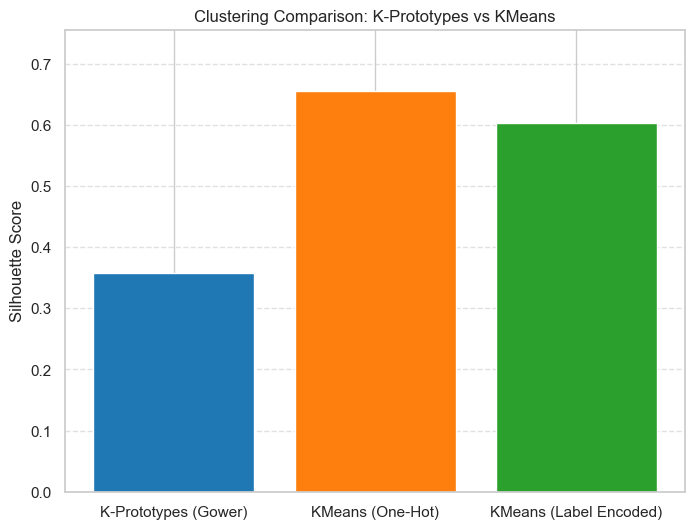

In [ ]:
# --- Gower distance for mixed data ---
X_for_gower = province_df.drop(columns=['cluster'], errors='ignore').copy()
gower_dist = gower.gower_matrix(X_for_gower)

print("\n=== Clustering Comparison (with Gower for K-Prototypes) ===")
print(f"K-Prototypes (Gower)        : {study.best_value:.3f}")
print(f"KMeans (One-Hot Encoded)    : {silhouette_ohe:.3f}")
print(f"KMeans (Label Encoded)      : {silhouette_le:.3f}")

# --- Bar Chart Comparison ---
scores = {
    "K-Prototypes (Gower)": study.best_value,
    "KMeans (One-Hot)": silhouette_ohe,
    "KMeans (Label Encoded)": silhouette_le,
}

plt.figure(figsize=(8,6))
plt.bar(scores.keys(), scores.values(), color=['#1f77b4','#ff7f0e','#2ca02c'])
plt.ylabel("Silhouette Score")
plt.title("Clustering Comparison: K-Prototypes vs KMeans")
plt.ylim(0, max(scores.values())+0.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA

FEATURE SPACE DIMENSIONALITY COMPARISON

           Method Original Features  Feature Space Dimensions    Dimensionality Impact
     K-Prototypes    15 num + 1 cat                        16    Native mixed handling
  K-Means (Label)    15 num + 1 cat                        16    Artificial ordinality
K-Means (One-Hot)    15 num + 1 cat                        31  Curse of dimensionality

⚠️ One-Hot Encoding increased dimensions by 93.8%


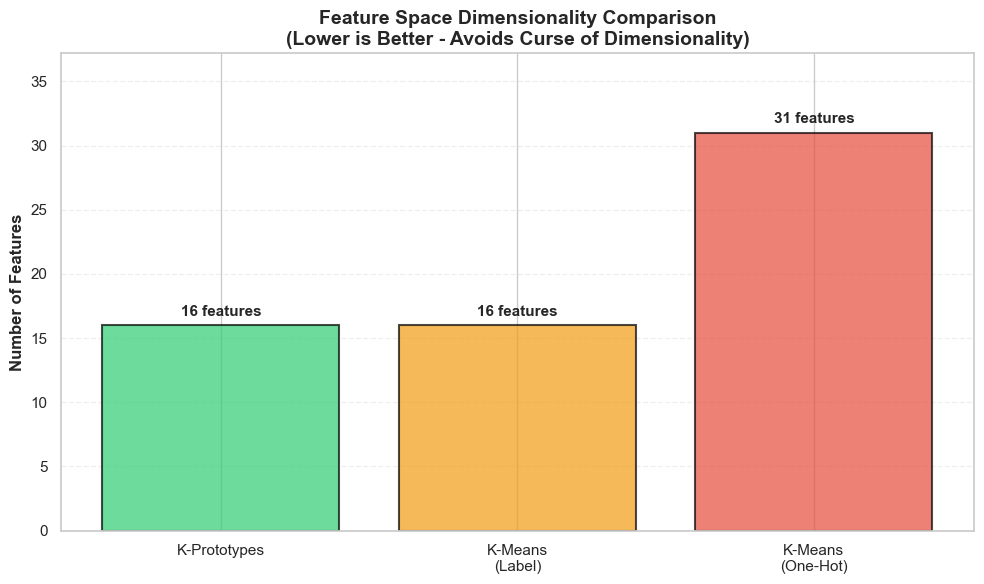


CLUSTER STABILITY ANALYSIS (Multiple Random Seeds)

Running clustering with 10 different random seeds...

Adjusted Rand Index (ARI) Statistics:
(Higher mean and lower std = More stable clustering)
           Method  Mean ARI  Std ARI  Min ARI  Max ARI
     K-Prototypes  0.767397 0.062458 0.619116 0.826583
K-Means (One-Hot)  0.957427 0.027870 0.939182 1.000000
  K-Means (Label)  0.969837 0.048597 0.876336 1.000000


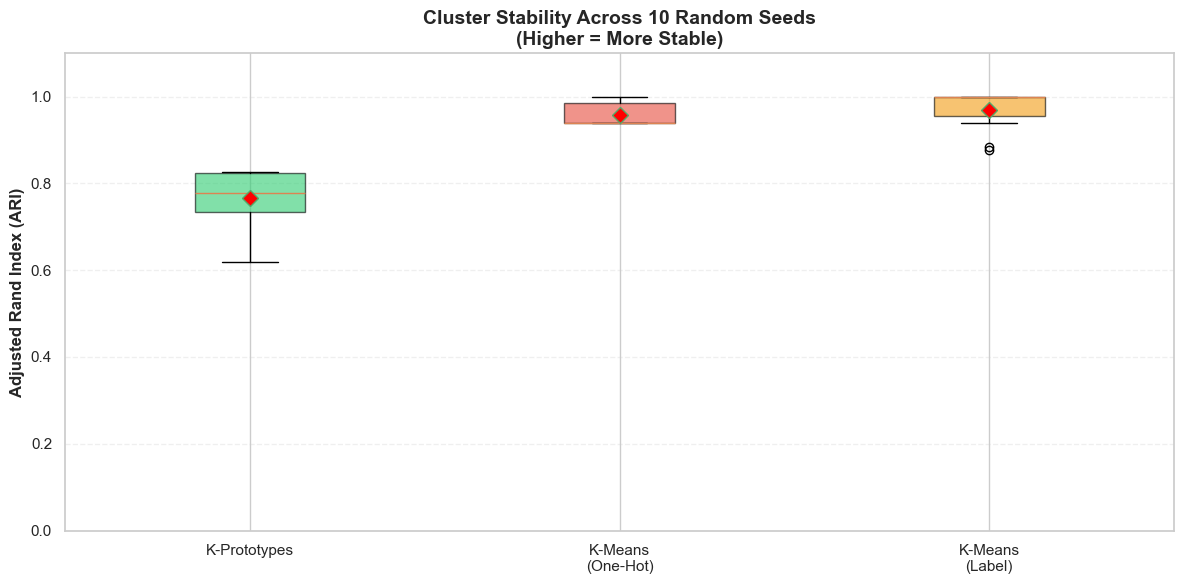

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

province_df_kmeans = province_df.copy()

# Separate numerical + categorical (same as in KPrototypes)
numerical_cols = province_df_kmeans.select_dtypes(include=np.number).columns.tolist()
categorical_cols = province_df_kmeans.select_dtypes(include="object").columns.tolist()

X_num = province_df_kmeans[numerical_cols].values
region = province_df_kmeans[categorical_cols].values  # assumes "Region" is in object dtype

print("="*80)
print("DEMONSTRATING K-PROTOTYPES ADVANTAGE FOR MIXED DATA")
print("="*80)

# FEATURE SPACE DIMENSIONALITY COMPARISON
print("\n" + "="*80)
print("FEATURE SPACE DIMENSIONALITY COMPARISON")
print("="*80)

# One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False, drop='first')
region_ohe = ohe.fit_transform(region)
X_ohe = np.hstack([X_num, region_ohe])

# Label Encoding
le = LabelEncoder()
region_le = le.fit_transform(region.ravel()).reshape(-1, 1)
X_le = np.hstack([X_num, region_le])

# Display dimensionality
dim_comparison = pd.DataFrame({
    'Method': ['K-Prototypes', 'K-Means (Label)', 'K-Means (One-Hot)'],
    'Original Features': [f"{len(numerical_cols)} num + {len(categorical_cols)} cat", 
                          f"{len(numerical_cols)} num + {len(categorical_cols)} cat",
                          f"{len(numerical_cols)} num + {len(categorical_cols)} cat"],
    'Feature Space Dimensions': [len(numerical_cols) + len(categorical_cols), 
                                  X_le.shape[1], 
                                  X_ohe.shape[1]],
    'Dimensionality Impact': ['Native mixed handling', 
                              ' Artificial ordinality', 
                              ' Curse of dimensionality']
})

print("\n" + dim_comparison.to_string(index=False))
print(f"\n⚠️ One-Hot Encoding increased dimensions by {((X_ohe.shape[1] / (len(numerical_cols) + len(categorical_cols))) - 1) * 100:.1f}%")

# Visualize dimensionality
fig, ax = plt.subplots(figsize=(10, 6))
methods = ['K-Prototypes', 'K-Means\n(Label)', 'K-Means\n(One-Hot)']
dimensions = [len(numerical_cols) + len(categorical_cols), X_le.shape[1], X_ohe.shape[1]]
colors = ['#2ecc71', '#f39c12', '#e74c3c']

bars = ax.bar(methods, dimensions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Space Dimensionality Comparison\n(Lower is Better - Avoids Curse of Dimensionality)', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(dimensions) * 1.2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, dim in zip(bars, dimensions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{dim} features',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# CLUSTER STABILITY ANALYSIS
print("\n" + "="*80)
print("CLUSTER STABILITY ANALYSIS (Multiple Random Seeds)")
print("="*80)

print("\nRunning clustering with 10 different random seeds...")

# Store results
n_runs = 10
stability_kproto = []
stability_ohe = []
stability_le = []

# Get K-Prototypes baseline clusters
baseline_kproto = final_df['cluster'].values

# Prepare data for K-Prototypes
X_kproto = province_df[numerical_cols + categorical_cols].values

for seed in range(n_runs):
    # K-Prototypes (re-run with different seed)
    kproto_temp = KPrototypes(n_clusters=3, init='Cao', random_state=seed, n_init=5, verbose=0)
    temp_labels_kproto = kproto_temp.fit_predict(X_kproto, categorical=[len(numerical_cols)])
    ari_kproto = adjusted_rand_score(baseline_kproto, temp_labels_kproto)
    stability_kproto.append(ari_kproto)
    
    # K-Means One-Hot
    kmeans_temp_ohe = KMeans(n_clusters=3, random_state=seed, n_init=10)
    temp_labels_ohe = kmeans_temp_ohe.fit_predict(X_ohe)
    ari_ohe = adjusted_rand_score(kmeans_ohe_labels, temp_labels_ohe)
    stability_ohe.append(ari_ohe)
    
    # K-Means Label
    kmeans_temp_le = KMeans(n_clusters=3, random_state=seed, n_init=10)
    temp_labels_le = kmeans_temp_le.fit_predict(X_le)
    ari_le = adjusted_rand_score(kmeans_le_labels, temp_labels_le)
    stability_le.append(ari_le)

# Calculate statistics
stability_stats = pd.DataFrame({
    'Method': ['K-Prototypes', 'K-Means (One-Hot)', 'K-Means (Label)'],
    'Mean ARI': [np.mean(stability_kproto), np.mean(stability_ohe), np.mean(stability_le)],
    'Std ARI': [np.std(stability_kproto), np.std(stability_ohe), np.std(stability_le)],
    'Min ARI': [np.min(stability_kproto), np.min(stability_ohe), np.min(stability_le)],
    'Max ARI': [np.max(stability_kproto), np.max(stability_ohe), np.max(stability_le)]
})

print("\nAdjusted Rand Index (ARI) Statistics:")
print("(Higher mean and lower std = More stable clustering)")
print(stability_stats.to_string(index=False))

# Visualize stability
fig, ax = plt.subplots(figsize=(12, 6))
positions = [1, 2, 3]
bp = ax.boxplot([stability_kproto, stability_ohe, stability_le],
                 positions=positions,
                 labels=['K-Prototypes', 'K-Means\n(One-Hot)', 'K-Means\n(Label)'],
                 patch_artist=True,
                 showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color boxes
colors = ['#2ecc71', '#e74c3c', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Adjusted Rand Index (ARI)', fontsize=12, fontweight='bold')
ax.set_title('Cluster Stability Across 10 Random Seeds\n(Higher = More Stable)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()



#### Showing the values

In [ ]:
# Filter the DataFrame to show only cluster 2
cluster_2_df = final_df[final_df['cluster'] == 2]

# Display the filtered DataFrame
# display(cluster_2_df)

### Evaluation

In [ ]:
# Cluster Evaluation (Silhouette, DBI, Dunn, McClain)
import gower
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from validclust import dunn

# --- Custom McClain Index ---
def mcclain_index(distance_matrix, labels):
    """
    McClain Index = (avg intra-cluster distance) / (avg inter-cluster distance)
    Lower is better.
    """
    labels = np.array(labels)
    n = len(labels)

    intra_dists = []
    inter_dists = []

    for i in range(n):
        for j in range(i + 1, n):
            if labels[i] == labels[j]:
                intra_dists.append(distance_matrix[i, j])
            else:
                inter_dists.append(distance_matrix[i, j])

    intra_mean = np.mean(intra_dists) if intra_dists else 0
    inter_mean = np.mean(inter_dists) if inter_dists else 1  # avoid div0
    return intra_mean / inter_mean

X_eval = final_df.drop(columns=["cluster"], errors="ignore")

# Convert categorical cols to string (needed for Gower)
for col in categorical_cols:
    X_eval[col] = X_eval[col].astype(str)

# Compute Gower distance (for all metrics)
print("Computing Gower distance matrix for evaluation...")
gower_dist = gower.gower_matrix(X_eval)
print("Gower distance computed!")

# Extract numeric part (for DBI only)
X_num = final_df[numerical_cols].values

results = {}

# Silhouette using Gower distance (higher = better)
results['Silhouette (Gower)'] = silhouette_score(gower_dist, final_df["cluster"], metric='precomputed')

# Davies-Bouldin Index (lower = better) - uses Euclidean on numerical features
results['Davies-Bouldin'] = davies_bouldin_score(X_num, final_df["cluster"])

# Dunn Index (higher = better)
results['Dunn'] = dunn(gower_dist, final_df["cluster"])

# McClain Index (lower = better)
results['McClain'] = mcclain_index(gower_dist, final_df["cluster"])

# --- 5. Print results ---
print("\n" + "="*50)
print("      CLUSTER EVALUATION METRICS")
print("="*50)
for metric, score in results.items():
    # Add interpretation
    if metric == 'Silhouette (Gower)':
        interpretation = "Higher is better (range: -1 to 1)"
    elif metric == 'Davies-Bouldin':
        interpretation = "Lower is better (0 to ∞)"
    elif metric == 'Dunn':
        interpretation = "Higher is better (0 to ∞)"
    elif metric == 'McClain':
        interpretation = "Lower is better (0 to ∞)"
    else:
        interpretation = ""

    print(f"{metric:.<30} {score:.4f}  ({interpretation})")
print("="*50)

Computing Gower distance matrix for evaluation...
Gower distance computed!

      CLUSTER EVALUATION METRICS
Silhouette (Gower)............ 0.3576  (Higher is better (range: -1 to 1))
Davies-Bouldin................ 2.5086  (Lower is better (0 to ∞))
Dunn.......................... 0.1127  (Higher is better (0 to ∞))
McClain....................... 0.5650  (Lower is better (0 to ∞))


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("K-PROTOTYPES CLUSTER VISUALIZATION")
print("(Using scaled numerical features only)")


# 1. PREPARE DATA - USE SCALED NUMERICAL FEATURES

# Extract numerical features from province_df (already scaled)
numeric_features = province_df.select_dtypes(include=np.number).columns.tolist()
if 'cluster' in numeric_features:
    numeric_features.remove('cluster')

# Use SCALED data for visualization
X_viz = province_df[numeric_features].copy()
clusters = final_df['cluster'].copy()

# Get province names from final_df index
province_names = final_df.index.tolist()

print(f"\nUsing SCALED numerical features: {len(numeric_features)}")
print(f"Samples (provinces): {len(X_viz)}")
print(f"Categorical feature (region) handled separately in K-Prototypes")

K-PROTOTYPES CLUSTER VISUALIZATION
(Using scaled numerical features only)

Using SCALED numerical features: 15
Samples (provinces): 92
Categorical feature (region) handled separately in K-Prototypes


PCA ANALYSIS ON SCALED NUMERICAL FEATURES

Explained Variance by Component:
  PC1: 0.6733 (67.33%) | Cumulative: 67.33%
  PC2: 0.1337 (13.37%) | Cumulative: 80.70%
  PC3: 0.0601 (6.01%) | Cumulative: 86.71%
  PC4: 0.0500 (5.00%) | Cumulative: 91.71%
  PC5: 0.0347 (3.47%) | Cumulative: 95.18%
  PC6: 0.0235 (2.35%) | Cumulative: 97.53%
  PC7: 0.0090 (0.90%) | Cumulative: 98.43%
  PC8: 0.0070 (0.70%) | Cumulative: 99.13%
  PC9: 0.0038 (0.38%) | Cumulative: 99.50%
  PC10: 0.0017 (0.17%) | Cumulative: 99.68%

Components needed for 90% variance: 4
Components needed for 95% variance: 5


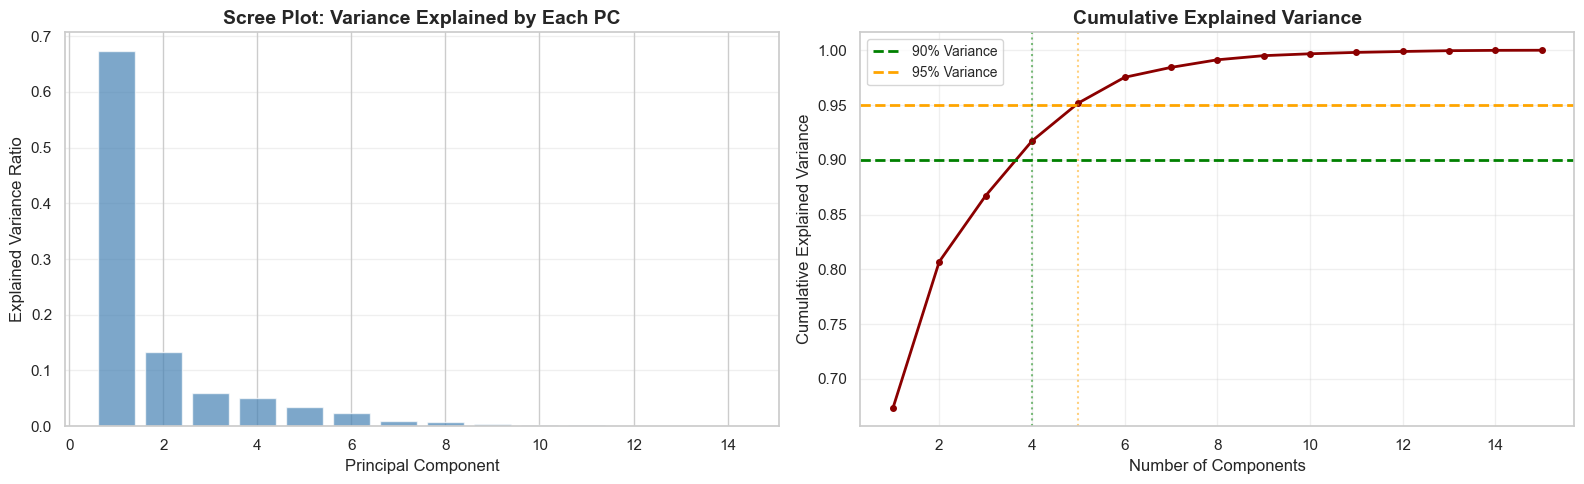

In [ ]:
# 2. PCA ANALYSIS WITH EXPLAINED VARIANCE
from sklearn.decomposition import PCA

print("PCA ANALYSIS ON SCALED NUMERICAL FEATURES")

# Perform PCA on scaled data
pca = PCA()

X_pca = pca.fit_transform(X_viz)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nExplained Variance by Component:")
for i, var in enumerate(pca.explained_variance_ratio_[:10], 1):
    cum_var = cumulative_variance[i-1]
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var*100:.2f}%")

print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# Visualization 1: Scree Plot & Cumulative Variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].bar(range(1, min(15, len(pca.explained_variance_ratio_)+1)),
            pca.explained_variance_ratio_[:14],
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Variance Explained by Each PC', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1),
             cumulative_variance,
             marker='o', linewidth=2, color='darkred', markersize=4)
axes[1].axhline(y=0.90, color='green', linestyle='--', label='90% Variance', linewidth=2)
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% Variance', linewidth=2)
axes[1].axvline(x=n_components_90, color='green', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_95, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 4. 3D PCA VISUALIZATION (Interactive)
print("3D PCA VISUALIZATION")

# Create PCA dataframe with first 3 components
pca_df = pd.DataFrame(X_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])

# Add cluster and province information
pca_df['cluster'] = clusters.values
pca_df['province'] = province_names

# Define cluster labels and colors (if not already defined)
cluster_labels = {
    0: "Moderate-Impact Typhoons",
    1: "High-Casualty Typhoons",
    2: "Low-Impact Typhoons"
}

cluster_colors = {
    0: '#3498db',  # Blue
    1: '#e74c3c',  # Red
    2: '#2ecc71'   # Green
}

# Add cluster labels for hover
pca_df['cluster_label'] = pca_df['cluster'].map(cluster_labels)

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color='cluster',
    hover_name='province',
    hover_data={'cluster_label': True, 'cluster': False},
    color_discrete_map=cluster_colors,
    title=f'3D PCA: K-Prototypes Clusters (Explains {cumulative_variance[2]*100:.1f}% variance)',
    labels={
        'PC1': f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
        'PC2': f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
        'PC3': f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
        'cluster': 'Cluster ID'
    }
)
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(height=700)
fig.show()

3D PCA VISUALIZATION


t-SNE VISUALIZATION (Non-linear dimensionality reduction)


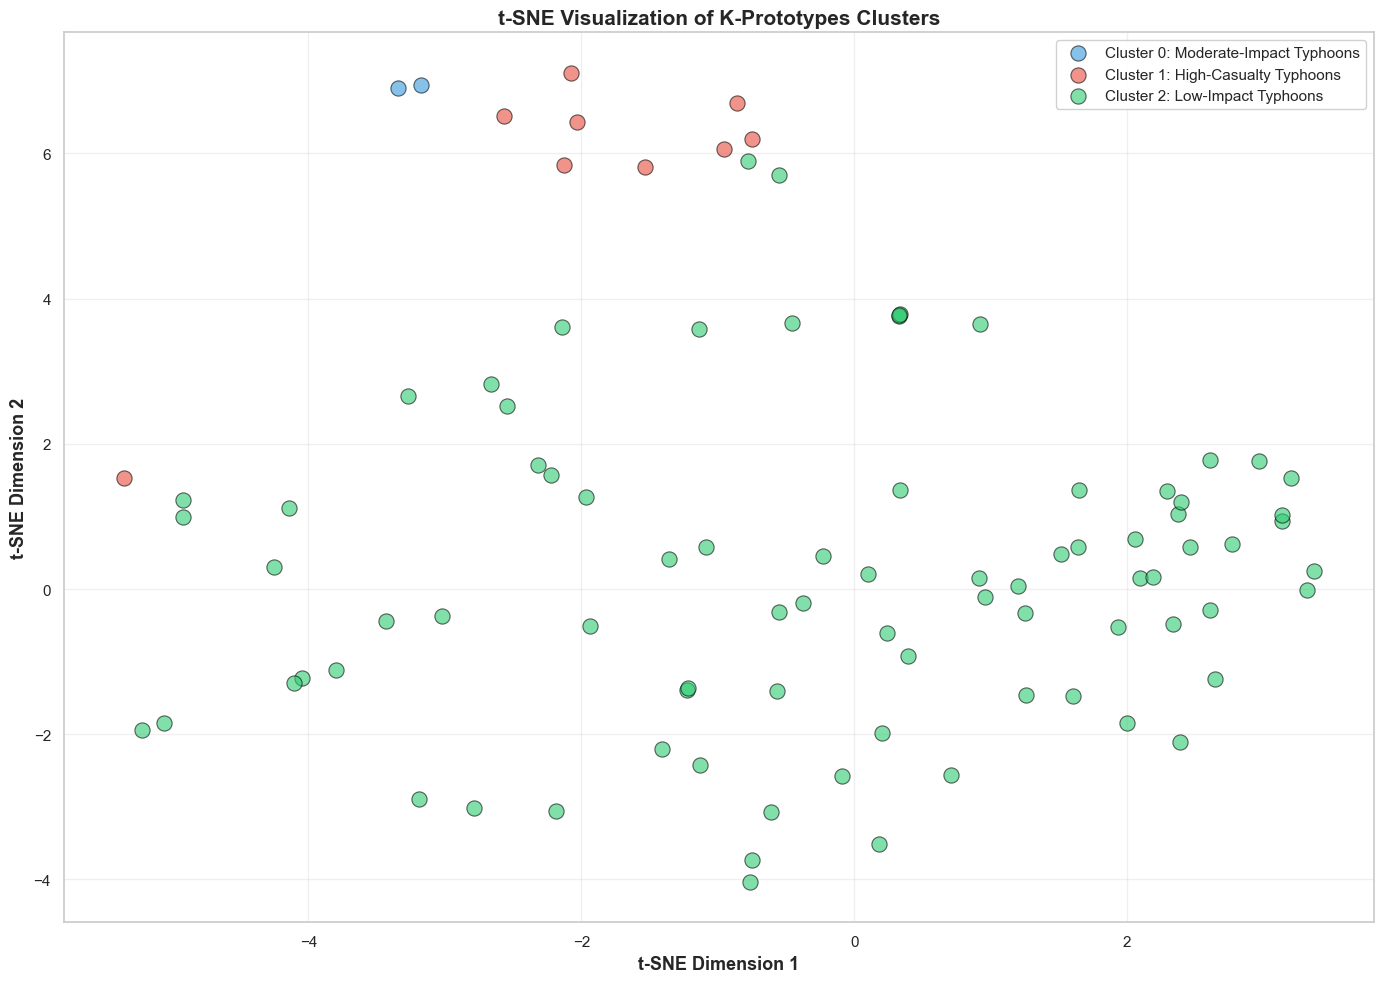

In [ ]:
# 5. t-SNE VISUALIZATION

print("t-SNE VISUALIZATION (Non-linear dimensionality reduction)")

perplexity_val = min(30, len(X_viz) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000)
X_tsne = tsne.fit_transform(X_viz)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = clusters.values
tsne_df['province'] = province_names

fig, ax = plt.subplots(figsize=(14, 10))

for cluster_id in sorted(tsne_df['cluster'].unique()):
    cluster_data = tsne_df[tsne_df['cluster'] == cluster_id]
    ax.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'],
               c=cluster_colors.get(cluster_id, 'gray'),
               label=f'Cluster {cluster_id}: {cluster_labels.get(cluster_id, "Unknown")}',
               alpha=0.6,
               s=120,
               edgecolors='black',
               linewidth=0.8)

ax.set_xlabel('t-SNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('t-SNE Visualization of K-Prototypes Clusters', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

FEATURE CONTRIBUTION TO PRINCIPAL COMPONENTS


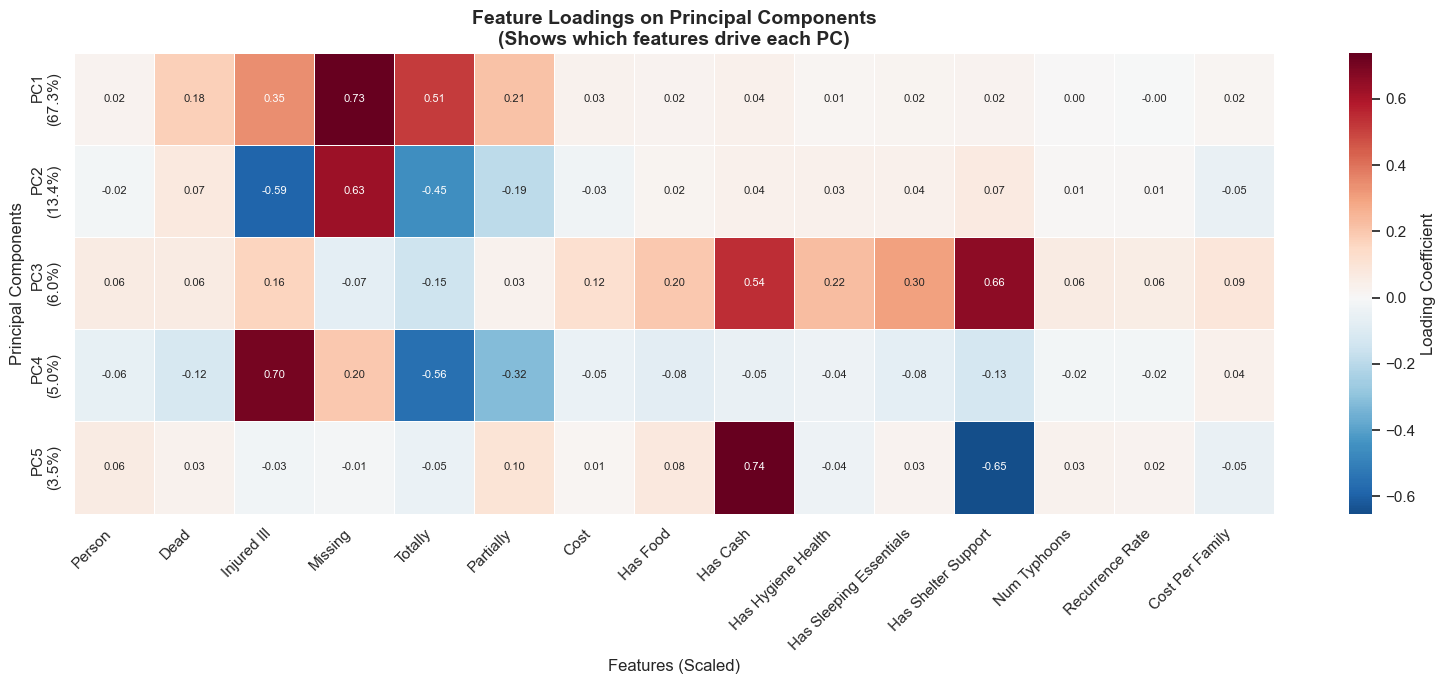

In [ ]:
# 6. COMPONENT CONTRIBUTION HEATMAP

print("FEATURE CONTRIBUTION TO PRINCIPAL COMPONENTS")

# Get top N components
n_top_components = min(5, len(pca.components_))
loading_matrix = pd.DataFrame(
    pca.components_[:n_top_components, :],
    columns=[f.replace('_sum', '').replace('_', ' ').title() for f in numeric_features],
    index=[f'PC{i+1}\n({pca.explained_variance_ratio_[i]*100:.1f}%)' for i in range(n_top_components)]
)

plt.figure(figsize=(16, 7))
sns.heatmap(loading_matrix, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, cbar_kws={'label': 'Loading Coefficient'},
            annot_kws={'size': 8})
plt.title('Feature Loadings on Principal Components\n(Shows which features drive each PC)',
          fontsize=14, fontweight='bold')
plt.xlabel('Features (Scaled)', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# 7. VARIANCE EXPLAINED TABLE & TOP FEATURE CONTRIBUTORS

variance_table = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(min(10, len(pca.explained_variance_ratio_)))],
    'Variance Explained': pca.explained_variance_ratio_[:10],
    'Cumulative Variance': cumulative_variance[:10]
})

print("\n" + "="*60)
print("VARIANCE EXPLAINED SUMMARY")
print("="*60)
print(variance_table.to_string(index=False, float_format='%.4f'))

# Show top contributors to first 3 PCs
print("\n" + "="*60)
print("TOP FEATURE CONTRIBUTORS PER COMPONENT")
print("="*60)

for pc_idx in range(min(3, len(pca.components_))):
    print(f"\nPC{pc_idx+1} (Explains {pca.explained_variance_ratio_[pc_idx]*100:.2f}% variance):")
    component_loadings = pd.DataFrame({
        'Feature': numeric_features,
        'Loading': pca.components_[pc_idx, :]
    }).sort_values('Loading', key=abs, ascending=False)

    print("  Top 5 positive contributors:")
    for _, row in component_loadings.head(5).iterrows():
        print(f"    {row['Feature']:.<40} {row['Loading']:>7.3f}")



print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)
print("\nNote: K-Prototypes uses both numerical AND categorical features")
print("for clustering, but PCA/t-SNE only visualize numerical features.")
print("The 'region' categorical variable influences cluster assignment")
print("but is not shown in these projections.")


VARIANCE EXPLAINED SUMMARY
Component  Variance Explained  Cumulative Variance
      PC1              0.6733               0.6733
      PC2              0.1337               0.8070
      PC3              0.0601               0.8671
      PC4              0.0500               0.9171
      PC5              0.0347               0.9518
      PC6              0.0235               0.9753
      PC7              0.0090               0.9843
      PC8              0.0070               0.9913
      PC9              0.0038               0.9950
     PC10              0.0017               0.9968

TOP FEATURE CONTRIBUTORS PER COMPONENT

PC1 (Explains 67.33% variance):
  Top 5 positive contributors:
    missing_sum.............................   0.734
    totally_sum.............................   0.510
    injured_ill_sum.........................   0.345
    partially_sum...........................   0.215
    dead_sum................................   0.178

PC2 (Explains 13.37% variance):
  Top 5 p

### MAACLI Framework

In [ ]:
final_df.head()

,region_,person_sum,dead_sum,injured_ill_sum,missing_sum,totally_sum,partially_sum,cost_sum,has_food_sum,has_cash_sum,has_hygiene_health_sum,has_sleeping_essentials_sum,has_shelter_support_sum,num_typhoons,recurrence_rate,cost_per_family,cluster
province_region,,,,,,,,,,,,,,,,,
ABRA (CAR),CAR,665436.0,2.0,115.0,0.0,58.0,888.0,2.946309e+07,61,46,8,4,4,29,5.800000,154.257011,2
AGUSAN DEL NORTE (CARAGA),CARAGA,189625.0,0.0,0.0,0.0,2876.0,9376.0,2.032942e+07,1,0,0,0,0,9,1.800000,451.313549,2
AGUSAN DEL SUR (CARAGA),CARAGA,221391.0,0.0,0.0,0.0,167.0,707.0,6.707485e+06,3,0,0,0,0,5,1.250000,120.374087,2
AKLAN (6),6,637351.0,8.0,2.0,1.0,273.0,9530.0,6.632630e+07,51,35,1,3,0,22,4.400000,388.050105,2
ALBAY (5),5,2402839.0,6.0,7.0,0.0,19277.0,105509.0,1.531597e+08,52,2,5,6,8,25,4.166667,246.731259,2


In [ ]:
final_df.columns = final_df.columns.str.strip()  # remove whitespace
final_df['region_'] = final_df['region_'].astype(str)  # categorical as string

# Only keep region as categorical (province_ is an ID, not useful for learning)
categorical_cols = ['region_']
numeric_cols = [col for col in final_df.columns if col not in categorical_cols + ['province_region', 'cluster']]

# Encode categorical for ML
df_encoded = final_df.copy()
for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[numeric_cols + categorical_cols]
y = df_encoded["cluster"]

# Train XGBoost
xgb = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200, random_state=42)
xgb.fit(X, y)

# Feature importance
print("Feature Importances:", xgb.feature_importances_)


perm_importance = permutation_importance(
    xgb, X, y,
    n_repeats=10,
    random_state=42,
    scoring='accuracy'
)

# Show top features per cluster (simplified)
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

print("\n=== GLOBAL FEATURE IMPORTANCE ===")
print(importance_df)


Feature Importances: [0.02340343 0.07477308 0.06330264 0.35329112 0.17119575 0.02792998
 0.05628738 0.0257528  0.00851522 0.08341026 0.01624059 0.00040043
 0.0021896  0.00546161 0.04454946 0.04329664]

=== GLOBAL FEATURE IMPORTANCE ===
                        feature  importance
3                   missing_sum    0.096739
9        has_hygiene_health_sum    0.016304
14              cost_per_family    0.007609
0                    person_sum    0.000000
4                   totally_sum    0.000000
5                 partially_sum    0.000000
1                      dead_sum    0.000000
2               injured_ill_sum    0.000000
7                  has_food_sum    0.000000
6                      cost_sum    0.000000
10  has_sleeping_essentials_sum    0.000000
8                  has_cash_sum    0.000000
11      has_shelter_support_sum    0.000000
12                 num_typhoons    0.000000
13              recurrence_rate    0.000000
15                      region_    0.000000


In [ ]:
# Prepare data for tree (encode categorical)
df_explain = final_df.copy()
df_explain['region_'] = df_explain['region_'].astype('category').cat.codes  # encode

# Features + target
X_tree = df_explain.drop(columns=['province_', 'cluster'], errors='ignore')
y_tree = df_explain['cluster']

# Train a shallow decision tree (for interpretability)
tree = DecisionTreeClassifier(
    max_depth=4,          # keep it simple
    min_samples_leaf=5,   # avoid overfitting
    random_state=42
)
tree.fit(X_tree, y_tree)

# Extract rules per cluster
rules = export_text(tree, feature_names=list(X_tree.columns))
print("=== DECISION TREE RULES ===")
print(rules)

=== DECISION TREE RULES ===
|--- missing_sum <= 3.50
|   |--- totally_sum <= 15298.50
|   |   |--- class: 2
|   |--- totally_sum >  15298.50
|   |   |--- class: 2
|--- missing_sum >  3.50
|   |--- has_hygiene_health_sum <= 7.50
|   |   |--- class: 0
|   |--- has_hygiene_health_sum >  7.50
|   |   |--- class: 1



In [ ]:
# Features you always want to add to descriptions
extra_features = [
    'has_hygiene_health_sum',
    'has_sleeping_essentials_sum',
    'has_shelter_support_sum',
    'recurrence_rate'
]

# Predefined cluster interpretations
cluster_labels = {
    0: "Moderate-Impact Typhoons Cyclones",
    1: "High-Casualty Typhoons Cyclones",
    2: "Low-Impact Typhoons Cyclones"
}

def describe_cluster(df, cluster_id, important_features, top_k=3):
    subset = df[df['cluster'] == cluster_id]

    # Add cluster title and interpretation label
    desc = f"**Cluster {cluster_id} – {cluster_labels.get(cluster_id, 'Unlabeled')}**\n"

    # Core features = top_k important + extras (unique)
    features_to_describe = list(dict.fromkeys(important_features[:top_k] + extra_features))

    # Add feature-based description
    for feat in features_to_describe:
        if feat in df.columns:  # only describe if exists in data
            if df[feat].dtype in ['object', 'category']:
                mode_val = subset[feat].mode().iloc[0] if not subset[feat].mode().empty else "N/A"
                desc += f"- {feat}: mostly '{mode_val}'\n"
            else:
                q1 = subset[feat].quantile(0.25)
                q3 = subset[feat].quantile(0.75)
                desc += f"- {feat}: 75% between {q1:,.0f} and {q3:,.0f}\n"

    return desc

top_features = [
    f for f in importance_df['feature'].tolist()
    
]

# Print descriptions
for cluster_id in sorted(final_df['cluster'].unique()):
    print(describe_cluster(final_df, cluster_id, top_features, top_k=3))


**Cluster 0 – Moderate-Impact Typhoons Cyclones**
- missing_sum: 75% between 12 and 14
- has_hygiene_health_sum: 75% between 0 and 0
- cost_per_family: 75% between 186 and 304
- has_sleeping_essentials_sum: 75% between 0 and 0
- has_shelter_support_sum: 75% between 0 and 0
- recurrence_rate: 75% between 2 and 3

**Cluster 1 – High-Casualty Typhoons Cyclones**
- missing_sum: 75% between 4 and 6
- has_hygiene_health_sum: 75% between 7 and 19
- cost_per_family: 75% between 419 and 1,024
- has_sleeping_essentials_sum: 75% between 5 and 19
- has_shelter_support_sum: 75% between 0 and 7
- recurrence_rate: 75% between 2 and 4

**Cluster 2 – Low-Impact Typhoons Cyclones**
- missing_sum: 75% between 0 and 0
- has_hygiene_health_sum: 75% between 0 and 4
- cost_per_family: 75% between 125 and 401
- has_sleeping_essentials_sum: 75% between 0 and 4
- has_shelter_support_sum: 75% between 0 and 1
- recurrence_rate: 75% between 2 and 4



In [ ]:
# final_df.to_csv("new.csv", index=False)


In [ ]:
province_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family'],
      dtype='object')

In [ ]:
final_df.columns

Index(['region_', 'person_sum', 'dead_sum', 'injured_ill_sum', 'missing_sum',
       'totally_sum', 'partially_sum', 'cost_sum', 'has_food_sum',
       'has_cash_sum', 'has_hygiene_health_sum', 'has_sleeping_essentials_sum',
       'has_shelter_support_sum', 'num_typhoons', 'recurrence_rate',
       'cost_per_family', 'cluster'],
      dtype='object')

In [ ]:
with open('cluster_explanations_MAACLI.txt', 'w') as f:
    f.write("=== MAACLI CLUSTER EXPLANATIONS ===\n\n")
    f.write("1. DECISION TREE RULES:\n")
    f.write(rules)
    f.write("\n2. CLUSTER DESCRIPTIONS:\n")
    for c in sorted(final_df['cluster'].unique()):
        f.write(describe_cluster(final_df, c, top_features))

Cluster 0 – Moderate-Impact Typhoons Cyclones

This cluster represents Typhoons Cyclones with moderate disaster costs, moderate food and relief distribution, and intermediate mortality levels. Affected provinces typically receive sustained support in hygiene, sleeping essentials, and shelter assistance, indicating significant but manageable relief operations. The recurrence rate of 4–5 events per year suggests these provinces are consistently exposed, requiring repeated preparedness and recovery cycles.

Cluster 1 – High-Casualty Typhoons Cyclones

This cluster is defined primarily by elevated death counts, despite moderate costs and limited relief distribution (food, hygiene, sleeping, shelter). The relatively low recurrence rate (2–3 events/year) suggests that although provinces here experience fewer Typhoons Cyclones, when disasters occur, they tend to be extremely lethal. This highlights cases of extreme vulnerability, insufficient preparedness, or unusually severe Typhoons Cyclones that overwhelm existing response capacity.

Cluster 2 – Low-Impact Typhoons Cyclones

This cluster contains Typhoons Cyclones with minimal economic costs, negligible mortality, and limited relief needs (very low hygiene, shelter, and sleeping support). The recurrence rate (2–4 events/year) indicates that these provinces are regularly affected, but the impacts remain low in severity, possibly due to weaker storm intensities or effective local mitigation and adaptation measures.